<div style="display: flex; background-color: RGB(119, 150, 203);">
    <h1 style="margin: auto; padding: 30px 30px 30px 30px; color: RGB(255,255,255);">
        <center>
            <b>Scoring : Projet Telecom</b><br/>
            <br/>
            Rime Boumezaoued, Romain Pénichon et Claire Gefflot<br/>
</div>

<div class="alert alert-block alert-info">
<b><u>Contexte du projet</b><br/>
<br/>
• Réalisation d’une étude<br/>
• <b>Données :</b> Comportement clients dans le domaine de la téléphonie mobile<br/>
• <b>Objectif :</b> Trouver le meilleur modèle de score permettant d’identifier au mieux les « churners »<br/>
• <b>Évènement cible :</b> Le « churn » (attrition, départ client) est défini comme l’entrée en période d’invalidité dans les 2 mois<br/>
• <b>Contexte :</b> 2 opérateurs mobiles (ope1 et ope2) + 1 fixe.<br/>
• Vous êtes “ope1”<br/>
• Mobile, prépayé, grand public<br/>
• <b>3 périodes :</b> validité (validity), grâce (grace: pas d’appels sortants), invalidité (after-grace: ni entrant ni sortant)<br/>
• <b>Types de recharges :</b> 25, 50, 100, 200 sesterces<br/>
• <b>Variable cible :</b> AFTERGRACE_FLAG<br/>

</div>

<a class="anchor" id="table_of_contents"></a>
## Sommaire

* [Data pre-processing](#chapter1)
    * [Import des packages et data](#section_1_1)
    * [Data cleaning](#section_1_2)
* [Exploration data analysis (EDA)](#chapter2)
* [Feature engineering](#chapter3)
    * [Création d'indicateur](#section_3_1)
    * [Pré-sélection des variables (Chi 2 et Student)](#section_3_2)
    * [Encoding et scaling (train et validation set)](#section_3_3)
    * [Sélection des variables - Regression logistique (RFE)](#section_3_4)
* [Modélisation](#chapter4)
    * [Régression logistique](#section_4_1)
    * [XGBoost](#section_4_2)
    * [LightGBM](#section_4_3)
* [Choix du modèle final : XGBoost](#chapter5)
    * [Analyse des résultats](#section_5_1)
    * [Identification des variables les plus importantes](#section_5_2)
    * [Interprétation du modèle](#section_5_3)
    * [Sérialisation du modèle et déploiement en situation réelle](#section_5_4)

<a class="anchor" id="chapter1"></a>
<div style="display: flex; background-color: RGB(119, 150, 203);">
    <h1 style="margin: auto; padding: 30px 30px 30px 30px; color: RGB(255,255,255);">
            <b>Data pre-processing</b>
</div>

<a class="anchor" id="section_1_1"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">Imports des packages et data</h3>
</div>

In [20]:
import pandas as pd
from pandas.api.types import is_numeric_dtype, is_object_dtype
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import scipy.stats as st
from pathlib import Path
import io
from unidecode import unidecode
from skimpy import skim
import sys
from statistics import mean
import warnings
import re

from sklearn.model_selection import train_test_split

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook

import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score, accuracy_score, mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, f1_score
import category_encoders as ce
from pre_processing import pre_processing


from sklearn.exceptions import DataConversionWarning
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool
from catboost import cv
import optuna
import joblib

import shap

In [21]:
# Read the dataset :

pd.set_option("display.min_rows", 10)
pd.set_option("display.max_column", 1000)

df = pd.read_csv('../DATA/base_projet_teleco.csv', index_col=False, sep=";")
df=df.iloc[:, 1:]
df

,CONTRACT_KEY,CUSTOMER_AGE,CUSTOMER_GENDER,CONTRACT_TENURE_DAYS,AVERAGE_CHARGE_6M,FAILED_RECHARGE_6M,AVERAGE_RECHARGE_TIME_6M,BALANCE_M3,BALANCE_M2,BALANCE_M1,FIRST_RECHARGE_VALUE,LAST_RECHARGE_VALUE,TIME_TO_GRACE,TIME_TO_AFTERGRACE,RECENCY_OF_LAST_RECHARGE,TOTAL_RECHARGE_6M,NO_OF_RECHARGES_6M,ZERO_BALANCE_IND_M3,ZERO_BALANCE_IND_M2,ZERO_BALANCE_IND_M1,PASS_GRACE_IND_M3,PASS_GRACE_IND_M2,PASS_GRACE_IND_M1,PASS_AFTERGRACE_IND_M3,PASS_AFTERGRACE_IND_M2,PASS_AFTERGRACE_IND_M1,DATA_FLAG,INT_FLAG,ROAM_FLAG,CURR_HANDSET_MODE,NUM_HANDSET_USED_6M,INC_DURATION_MINS_M1,INC_DURATION_MINS_M2,INC_DURATION_MINS_M3,INC_PROP_SMS_CALLS_M1,INC_PROP_SMS_CALLS_M2,INC_PROP_SMS_CALLS_M3,INC_PROP_OPE1__MIN_M1,INC_PROP_OPE1__MIN_M2,INC_PROP_OPE1__MIN_M3,INC_PROP_OPE2_MIN_M1,INC_PROP_OPE2_MIN_M2,INC_PROP_OPE2_MIN_M3,INC_PROP_FIXED_MIN_M1,INC_PROP_FIXED_MIN_M2,INC_PROP_FIXED_MIN_M3,OUT_DURATION_MINS_M1,OUT_DURATION_MINS_M2,OUT_DURATION_MINS_M3,OUT_SMS_NO_M1,OUT_SMS_NO_M2,OUT_SMS_NO_M3,OUT_INT_DURATION_MINS_M1,OUT_INT_DURATION_MINS_M2,OUT_INT_DURATION_MINS_M3,OUT_888_DURATION_MINS_M1,OUT_888_DURATION_MINS_M2,OUT_888_DURATION_MINS_M3,OUT_VMACC_NO_CALLS_M1,OUT_VMACC_NO_CALLS_M2,OUT_VMACC_NO_CALLS_M3,OUT_PROP_SMS_CALLS_M1,OUT_PROP_SMS_CALLS_M2,OUT_PROP_SMS_CALLS_M3,OUT_PROP_OPE1__MIN_M1,OUT_PROP_OPE1__MIN_M2,OUT_PROP_OPE1__MIN_M3,OUT_PROP_OPE2_MIN_M1,OUT_PROP_OPE2_MIN_M2,OUT_PROP_OPE2_MIN_M3,OUT_PROP_FIXED_MIN_M1,OUT_PROP_FIXED_MIN_M2,OUT_PROP_FIXED_MIN_M3,INC_OUT_PROP_DUR_MIN_M1,INC_OUT_PROP_DUR_MIN_M2,INC_OUT_PROP_DUR_MIN_M3,AFTERGRACE_FLAG
0,46.0,49.0,b'Male',1735.0,66.67,1.0,27.0,15.83,8.83,23.83,100.0,50.0,-24.0,-34.0,6.0,400.0,7.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,b'6110',14.0,1274.0,861.0,243.0,0.00,0.01,0.04,0.99,0.86,0.97,0.01,0.05,0.03,0.00,0.08,0.00,16.0,37.0,23.0,8.0,11.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.62,0.37,2.00,0.50,0.86,0.39,0.00,0.00,0.13,0.38,0.08,0.35,79.63,23.27,10.57,1.0
1,47.0,99.0,b'Male',1735.0,33.33,0.0,97.0,284.13,207.83,178.13,100.0,100.0,-15.0,-45.0,75.0,200.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,b'3310',5.0,145.0,501.0,32.0,0.00,0.00,0.05,0.50,0.36,0.28,0.01,0.05,0.13,0.48,0.59,0.59,19.0,45.0,9.0,1.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.06,0.04,0.00,0.58,0.51,0.33,0.16,0.11,0.11,0.16,0.24,0.33,7.63,11.13,3.56,0.0
2,55.0,99.0,b'Male',1734.0,50.00,0.0,36.0,24.72,46.77,1.87,100.0,100.0,-51.0,-81.0,39.0,300.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,b'Nokia 3510',6.0,238.0,392.0,293.0,0.00,0.02,0.17,0.47,0.35,0.40,0.31,0.38,0.07,0.22,0.28,0.53,33.0,52.0,59.0,4.0,9.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.21,0.28,0.49,0.09,0.37,0.20,0.24,0.54,0.53,0.03,0.00,0.02,7.21,7.54,4.97,1.0
3,62.0,50.0,b'Male',1724.0,16.67,0.0,99.0,21.53,89.43,70.43,100.0,100.0,-40.0,-70.0,50.0,100.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,b'6110',7.0,113.0,51.0,16.0,0.10,0.09,0.18,0.51,0.65,0.25,0.12,0.31,0.38,0.36,0.04,0.38,10.0,14.0,0.0,8.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.89,0.36,0.00,0.30,0.14,0.00,0.50,0.21,0.00,0.20,0.29,0.00,11.30,3.64,-16.00,0.0
4,148.0,22.0,b'Male',1735.0,25.00,0.0,18.0,28.84,8.54,8.39,100.0,25.0,-9.0,-14.0,1.0,150.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,b'Nokia 6210',18.0,556.0,404.0,0.0,0.01,0.00,0.00,0.45,0.68,0.00,0.06,0.03,0.00,0.48,0.27,0.00,15.0,48.0,0.0,4.0,7.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.29,0.17,0.00,0.07,0.27,0.00,0.13,0.21,0.00,0.20,0.10,0.00,37.07,8.42,0.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49066,3216840.0,51.0,b'Unknown',185.0,16.67,0.0,119.0,77.00,45.30,21.30,100.0,100.0,-23.0,-53.0,67.0,100.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,b'8210',2.0,64.0,72.0,34.0,0.29,0.19,0.17,0.45,0.47,0.47,0.20,0.06,0.35,0.34,0.47,

<a class="anchor" id="section_1_2"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">Exploration des données</h3>
</div>

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49071 entries, 0 to 49070
Data columns (total 77 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CONTRACT_KEY              49071 non-null  float64
 1   CUSTOMER_AGE              49071 non-null  float64
 2   CUSTOMER_GENDER           49071 non-null  object 
 3   CONTRACT_TENURE_DAYS      49071 non-null  float64
 4   AVERAGE_CHARGE_6M         49061 non-null  float64
 5   FAILED_RECHARGE_6M        49071 non-null  float64
 6   AVERAGE_RECHARGE_TIME_6M  49060 non-null  float64
 7   BALANCE_M3                49071 non-null  float64
 8   BALANCE_M2                49071 non-null  float64
 9   BALANCE_M1                49071 non-null  float64
 10  FIRST_RECHARGE_VALUE      49068 non-null  float64
 11  LAST_RECHARGE_VALUE       49068 non-null  float64
 12  TIME_TO_GRACE             49068 non-null  float64
 13  TIME_TO_AFTERGRACE        49068 non-null  float64
 14  RECENC

In [23]:
def df_analyse(df, columns, name_df):
    """
    Initial analysis on the DataFrame.

    Parameters
    ----------
    Args:
        df (pandas.DataFrame): DataFrame to analyze.
        columns (list): Dataframe keys in list format.
        name_df (str): DataFrame name.

    Returns:
        None.
        Print the initial analysis on the DataFrame.
    """

    # Calculating the memory usage based on dataframe.info()
    buf = io.StringIO()
    df.info(buf=buf)
    memory_usage = buf.getvalue().split('\n')[-2]

    if df.empty:
        print("The", name_df, "dataset is empty. Please verify the file.")
    else:
        # identifying empty columns
        empty_cols = [col for col in df.columns if df[col].isna().all()]
        #identifying full duplicates rows
        df_rows_duplicates = df[df.duplicated()]

        # Creating a dataset based on Type object and records by columns
        type_cols = df.dtypes.apply(lambda x: x.name).to_dict()
        df_resume = pd.DataFrame(list(type_cols.items()), columns = ["Name", "Type"])
        df_resume["Records"] = list(df.count())
        df_resume["% of NaN"] = list(round((df.isnull().sum(axis = 0))/len(df),5)*100)
        df_resume["Unique"] = list(df.nunique())


        print("\nInitial Analysis of", name_df, "dataset")
        print("--------------------------------------------------------------------------")
        print("- Dataset shape:                 ", df.shape[0], "rows and", df.shape[1], "columns")
        print("- Total of NaN values:           ", df.isna().sum().sum())
        #print("- Percentage of NaN:             ", round((df.isna().sum().sum() / prod(df.shape)) * 100, 2), "%")
        print("- Total of full duplicates rows: ", df_rows_duplicates.shape[0])
        print("- Total of empty rows:           ", df.shape[0] - df.dropna(axis="rows", how="all").shape[0]) if df.dropna(axis="rows", how="all").shape[0] < df.shape[0] else \
                    print("- Total of empty rows:            0")
        print("- Total of empty columns:        ", len(empty_cols))
        print("  + The empty column is:         ", empty_cols) if len(empty_cols) == 1 else \
                    print("  + The empty column are:         ", empty_cols) if len(empty_cols) >= 1 else None

        print("\n- The key(s):", columns, "is not present multiple times in the dataframe.\n  It CAN be used as a primary key.") if df.size == df.drop_duplicates(columns).size else \
                    print("\n- The key(s):", columns, "is present multiple times in the dataframe.\n  It CANNOT be used as a primary key.")

        print("\n- Type object and records by columns         (",memory_usage,")")
        print("--------------------------------------------------------------------------")
        print(df_resume.sort_values("Records", ascending=False))



# Analyse df
df_analyse(df, ["CONTRACT_KEY"], "df")


Initial Analysis of df dataset
--------------------------------------------------------------------------
- Dataset shape:                  49071 rows and 77 columns
- Total of NaN values:            13700
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0

- The key(s): ['CONTRACT_KEY'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns         ( memory usage: 28.8+ MB )
--------------------------------------------------------------------------
                      Name     Type  Records  % of NaN  Unique
0             CONTRACT_KEY  float64    49071     0.000   49071
17     ZERO_BALANCE_IND_M3  float64    49071     0.000       2
1             CUSTOMER_AGE  float64    49071     0.000     117
25  PASS_AFTERGRACE_IND_M1  float64    49071     0.000       2
24  PASS_AFTERGRACE_IND_M2  float64    49071     0.000       2
..                     ...      ...      ...

<a class="anchor" id="section_1_3"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">Data cleaning</h3>
</div

In [24]:
#drop "CONTRACT_KEY":
df.drop(["CONTRACT_KEY"], axis=1, inplace=True)

In [25]:
#lowercase caracter :
df = df.applymap(lambda s:s.lower() if type(s) == str else s)

In [26]:
# study the type and the number of unique value of each covariate
df_nunique = pd.concat([df.nunique(), df.dtypes], axis=1).rename(columns={0: 'nunique', 1: 'dtypes'})
df_nunique

,nunique,dtypes
CUSTOMER_AGE,117,float64
CUSTOMER_GENDER,4,object
CONTRACT_TENURE_DAYS,1552,float64
AVERAGE_CHARGE_6M,130,float64
FAILED_RECHARGE_6M,35,float64
...,...,...
OUT_PROP_FIXED_MIN_M3,98,float64
INC_OUT_PROP_DUR_MIN_M1,4513,float64
INC_OUT_PROP_DUR_MIN_M2,4367,float64
INC_OUT_PROP_DUR_MIN_M3,4674,float64


In [27]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 49071  │ │ float64     │ 74    │                                                          │
│ │ Number of columns │ 76     │ │ string      │ 2     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name              ┃ NA   ┃ NA %     ┃ mean     ┃ sd      ┃ p0     ┃ p25   ┃ p75   ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │ CUSTOMER_AGE             │    0 │        0 │       46 │      28 │    -49 │    26 │    51 │     99 │   ▃█▁▃ │  │
│ │ CONTRACT_TENURE_DAYS     │    0 │        0 │      870 │     500 │    120 │   520 │  1200 │  38000 │   █    │  │
│ │ AVERAGE_CHARGE_6M        │   10 │     0.02 │       36 │      33 │    8.3 │    17 │    42 │   1800 │   █    │  │
│ │ FAILED_RECHARGE_6M       │    0 │        0 │     0.74 │       2 │      0 │     0 │     1 │     37 │   █    │  │
│ │ AVERAGE_RECHARGE_TIM     │   11 │    0.022 │       72 │      34 │      0 │    43 │   100 │    220 │  ▄█▆▅  │  │
│ │ BALANCE_M3               │    0 │        0 │       58 │      79 │      0 │   3.8 │    80 │   1300 │   █    │  │
│ │ BALANCE_M2               │    0 │        0 │       68 │      82 │      0 │   8.9 │    88 │   1300 │   █    │  │
│ │ BALANCE_M1               │    0 │        0 │       62 │      83 │      0 │   5.5 │    84 │   1300 │   █    │  │
│ │ FIRST_RECHARGE_VALUE     │    3 │   0.0061 │       86 │      27 │     25 │   100 │   100 │    200 │  ▃ █   │  │
│ │ LAST_RECHARGE_VALUE      │    3 │   0.0061 │       85 │      26 │     25 │    50 │   100 │    200 │  ▃ █   │  │
│ │ TIME_TO_GRACE            │    3 │   0.0061 │      -29 │      30 │   -120 │   -50 │    -7 │    550 │   █▃   │  │
│ │ TIME_TO_AFTERGRACE       │    3 │   0.0061 │      -53 │      35 │   -180 │   -80 │   -25 │    520 │   ▆█   │  │
│ │ RECENCY_OF_LAST_RECH     │    3 │   0.0061 │       44 │      31 │      1 │    17 │    61 │    640 │   █    │  │
│ │ TOTAL_RECHARGE_6M        │   11 │    0.022 │      230 │     200 │     50 │   180 │   250 │  11000 │   █    │  │
│ │ NO_OF_RECHARGES_6M       │   11 │    0.022 │      3.3 │       4 │      1 │     2 │     4 │    220 │   █    │  │
│ │ ZERO_BALANCE_IND_M3      │    0 │        0 │     0.34 │    0.47 │      0 │     0 │     1 │      1 │ █    ▄ │  │
│ │ ZERO_BALANCE_IND_M2      │    0 │        0 │     0.35 │    0.48 │      0 │     0 │     1 │      1 │ █    ▄ │  │
│ │ ZERO_BALANCE_IND_M1      │    0 │        0 │     0.32 │    0.47 │      0 │     0 │     1 │      1 │ █    ▄ │  │
│ │ PASS_GRACE_IND_M3        │    0 │        0 │      0.5 │     0.5 │      0 │     0 │     1 │      1 │ █    █ │  │
│ │ PASS_GRACE_IND_M2        │    0 │        0 │     0.48 │     0.5 │      0 │     0 │     1 │      1 │ █    ▇ │  │
│ │ PASS_GRACE_IND_M1        │    0 │        0 │     0.36 │    0.48 │      0 │     0 │     1 │      1 │ █    ▄ │  │
│ │ PASS_AFTERGRACE_IND_     │    0 │        0 │    0.054 │    0.23 │      0 │     0 │     0 │      1 │   █    │  │
│ │ PASS_AFTERGRACE_IND_     │    0 │        0 │    0.05

In [28]:
# analyse if there is any anomaly before fillna : until PASS_AFTERGRACE_IND_M1
df_describe = (df.describe()).T
df_describe

,count,mean,std,min,25%,50%,75%,max
CUSTOMER_AGE,49071.0,45.832997,28.141603,-49.00,26.00,36.00,51.00,99.00
CONTRACT_TENURE_DAYS,49071.0,873.929694,498.865053,118.00,524.00,848.00,1154.00,37862.00
AVERAGE_CHARGE_6M,49061.0,35.918847,33.333840,8.33,16.67,33.33,41.67,1770.83
FAILED_RECHARGE_6M,49071.0,0.743148,1.966795,0.00,0.00,0.00,1.00,37.00
AVERAGE_RECHARGE_TIME_6M,49060.0,72.442968,33.793581,0.00,43.00,71.00,105.00,216.00
...,...,...,...,...,...,...,...,...
OUT_PROP_FIXED_MIN_M3,49027.0,0.104286,0.169555,0.00,0.00,0.00,0.14,1.00
INC_OUT_PROP_DUR_MIN_M1,48793.0,9.234291,43.884409,-1988.00,1.43,3.82,9.52,1545.00
INC_OUT_PROP_DUR_MIN_M2,48793.0,9.081593,39.503773,-2895.00,1.38,3.68,8.96,1209.00
INC_OUT_PROP_DUR_MIN_M3,48793.0,10.126263,46.650065,-1047.00,1.30,3.86,10.19,2511.00


<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: black; ">Traitements des valeurs anormales</h3>
</div

In [29]:
#CUSTOMER_AGE : 18 to 100 year old
#Est-il possible que les customer_age soit entre 0 et 99 ans ?
display(df["CUSTOMER_AGE"].unique())


df["CUSTOMER_AGE"] = df["CUSTOMER_AGE"].apply(lambda x : np.nan if np.abs(x)<18 else np.abs(x))
display(df["CUSTOMER_AGE"].unique())

array([ 49.,  99.,  50.,  22.,  39.,  59.,  32.,  40.,  38.,  25.,  36.,
        42.,  27.,  28.,  54.,  34.,  58.,  62.,  46.,  51.,  48.,  45.,
        29.,  47.,  31.,  63.,  26.,  19.,  56.,  33.,  52.,  35.,  37.,
        41.,  44.,  24.,  60.,  43.,  21.,  30.,  55.,  53.,  57.,  69.,
        16.,  23.,  64.,  65.,  67.,  72.,  17.,  20.,  74.,   5.,  61.,
        66.,  12.,   9.,  18.,  76.,  71.,  83.,   1.,  15.,  68.,  73.,
        70.,  11.,  75.,  13.,   2., -31.,   7.,  14., -36., -37.,   3.,
         0.,  10.,   4.,  82.,   8., -25., -32.,  -1.,   6., -49., -33.,
       -10., -45., -22., -29., -38., -24.,  77., -17., -35., -34., -26.,
        -5.,  90., -44., -41.,  78.,  79.,  -2.,  86., -20., -42., -40.,
       -16., -46., -15., -30., -47., -48.,  80.])

array([49., 99., 50., 22., 39., 59., 32., 40., 38., 25., 36., 42., 27.,
       28., 54., 34., 58., 62., 46., 51., 48., 45., 29., 47., 31., 63.,
       26., 19., 56., 33., 52., 35., 37., 41., 44., 24., 60., 43., 21.,
       30., 55., 53., 57., 69., nan, 23., 64., 65., 67., 72., 20., 74.,
       61., 66., 18., 76., 71., 83., 68., 73., 70., 75., 82., 77., 90.,
       78., 79., 86., 80.])

In [30]:
#CUSTOMER_GENDER : Genre client
display(df["CUSTOMER_GENDER"].unique())

df["CUSTOMER_GENDER"] = df["CUSTOMER_GENDER"].apply(lambda x : x.split("'")[1])
df["CUSTOMER_GENDER"] = df["CUSTOMER_GENDER"].apply(lambda x: np.nan if (x=="not ent" or x=="unknown") else x) #lambda x: "unknown" if (x=="not ent" or x=="unknown") else x

display(df["CUSTOMER_GENDER"].unique())

array(["b'male'", "b'not ent'", "b'unknown'", "b'female'"], dtype=object)

array(['male', nan, 'female'], dtype=object)

In [31]:
#CONTRACT_TENURE_DAYS : Ancienneté contrat en jours
"""
We know that :
-Age min for contrat : 18
If CONTRACT_TENURE_DAYS=365 = 365/365=1, then the minimum age = 18+1=19

if current age - (CONTRACT_TENURE_DAYS/365) < 18
then : replace by np.nan
else : it's good
"""

df["age_first_contract"] = df["CUSTOMER_AGE"] - (df["CONTRACT_TENURE_DAYS"]/365)
df.loc[df['age_first_contract'] < 18, 'CONTRACT_TENURE_DAYS'] = np.nan
df.drop(["age_first_contract"], axis=1, inplace=True)

In [32]:
# 'NO_OF_RECHARGES_6M' :
df.loc[(df['NO_OF_RECHARGES_6M']-df['FAILED_RECHARGE_6M']) < 0, 'NO_OF_RECHARGES_6M'] = np.nan

Aucune erreurs à signaler sur ces variables :
AVERAGE_CHARGE_6M, FAILED_RECHARGE_6M, AVERAGE_RECHARGE_TIME_6M, BALANCE_M3, BALANCE_M2, BALANCE_M1, FIRST_RECHARGE_VALUE, LAST_RECHARGE_VALUE, TIME_TO_GRACE, TIME_TO_AFTERGRACE, RECENCY_OF_LAST_RECHARGE, TOTAL_RECHARGE_6M, ZERO_BALANCE_IND_M3, ZERO_BALANCE_IND_M2, ZERO_BALANCE_IND_M1, PASS_GRACE_IND_M3, PASS_GRACE_IND_M2, PASS_GRACE_IND_M1, PASS_AFTERGRACE_IND_M3, PASS_AFTERGRACE_IND_M2, PASS_AFTERGRACE_IND_M1

<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: black; ">Transformation des variables</h3>
</div

In [33]:
#phones_data = pd.read_excel("marque_telephone.xlsx")
phones_data = pd.read_excel("../DATA/marque_telephone.xlsx")
phones_data = phones_data.applymap(lambda x: x.lower() if isinstance(x, str) else x)

duplicates = phones_data.duplicated(subset='model', keep=False)

# Supprimer les doublons de l'index dans phones_data
phones_data = phones_data.drop_duplicates(subset='model')

# Créer une nouvelle colonne 'Marque' dans df
df['marque'] = df['CURR_HANDSET_MODE'].map(phones_data.set_index('model')['marque_tel'])

#drop "CURR_HANDSET_MODE":
df.drop(["CURR_HANDSET_MODE"], axis=1, inplace=True)

In [34]:
df['marque'].value_counts()

nokia            30841
ericsson          3012
alcatel           2352
samsung           2074
siemens           1887
motorola          1392
unknown            329
sony               174
sony ericsson      134
sagem               98
mitsubishi          83
lg                  27
panasonic           16
philips             16
sewon               14
xoceco               9
zte                  1
Name: marque, dtype: int64

In [35]:
# proportion de valeurs négatives pour les trois variables concernées
col = ["INC_OUT_PROP_DUR_MIN_M1", "INC_OUT_PROP_DUR_MIN_M2", "INC_OUT_PROP_DUR_MIN_M3"]
for elem in col :
    df[elem] = np.where(df[elem] < 0, np.abs(df[elem]), df[elem])

In [36]:
df.CONTRACT_TENURE_DAYS.sort_values(ascending=False)

277      1740.0
57       1740.0
34       1739.0
56       1738.0
3123     1737.0
          ...  
48917       NaN
48922       NaN
48939       NaN
48963       NaN
49017       NaN
Name: CONTRACT_TENURE_DAYS, Length: 49071, dtype: float64

<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: black; ">Analyse des résultats</h3>
</div

In [37]:
df_describe = (df.describe()).T
df_describe

,count,mean,std,min,25%,50%,75%,max
CUSTOMER_AGE,47530.0,46.984010,27.789268,18.00,27.00,37.00,51.00,99.00
CONTRACT_TENURE_DAYS,46127.0,866.683938,406.938234,118.00,519.00,833.00,1151.00,1740.00
AVERAGE_CHARGE_6M,49061.0,35.918847,33.333840,8.33,16.67,33.33,41.67,1770.83
FAILED_RECHARGE_6M,49071.0,0.743148,1.966795,0.00,0.00,0.00,1.00,37.00
AVERAGE_RECHARGE_TIME_6M,49060.0,72.442968,33.793581,0.00,43.00,71.00,105.00,216.00
...,...,...,...,...,...,...,...,...
OUT_PROP_FIXED_MIN_M3,49027.0,0.104286,0.169555,0.00,0.00,0.00,0.14,1.00
INC_OUT_PROP_DUR_MIN_M1,48793.0,13.239537,42.846543,0.00,1.54,4.00,10.05,1988.00
INC_OUT_PROP_DUR_MIN_M2,48793.0,11.615523,38.834289,0.00,1.45,3.80,9.29,2895.00
INC_OUT_PROP_DUR_MIN_M3,48793.0,14.546282,45.466177,0.00,1.45,4.10,11.00,2511.00


In [38]:
#see which col have NaN value :
df_na = (pd.DataFrame(df.isna().sum())).rename(columns={0: 'Sum_NaN'})
df_na

,Sum_NaN
CUSTOMER_AGE,1541
CUSTOMER_GENDER,459
CONTRACT_TENURE_DAYS,2944
AVERAGE_CHARGE_6M,10
FAILED_RECHARGE_6M,0
...,...
INC_OUT_PROP_DUR_MIN_M1,278
INC_OUT_PROP_DUR_MIN_M2,278
INC_OUT_PROP_DUR_MIN_M3,278
AFTERGRACE_FLAG,0



<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: black; ">Imputation des valeurs manquantes</h3>
</div

Afin d'éviter tout biais au sein de nos ensembles de données lors des imputations de valeurs manquantes, nous procédons immédiatement au split.

### Split data

In [39]:
target = "AFTERGRACE_FLAG"
df_train, df_val = train_test_split(df, test_size=0.2, stratify=df[target], random_state=14)

In [40]:
df_train.reset_index(drop = True, inplace=True)
df_val.reset_index(drop = True, inplace=True)

df_train

,CUSTOMER_AGE,CUSTOMER_GENDER,CONTRACT_TENURE_DAYS,AVERAGE_CHARGE_6M,FAILED_RECHARGE_6M,AVERAGE_RECHARGE_TIME_6M,BALANCE_M3,BALANCE_M2,BALANCE_M1,FIRST_RECHARGE_VALUE,LAST_RECHARGE_VALUE,TIME_TO_GRACE,TIME_TO_AFTERGRACE,RECENCY_OF_LAST_RECHARGE,TOTAL_RECHARGE_6M,NO_OF_RECHARGES_6M,ZERO_BALANCE_IND_M3,ZERO_BALANCE_IND_M2,ZERO_BALANCE_IND_M1,PASS_GRACE_IND_M3,PASS_GRACE_IND_M2,PASS_GRACE_IND_M1,PASS_AFTERGRACE_IND_M3,PASS_AFTERGRACE_IND_M2,PASS_AFTERGRACE_IND_M1,DATA_FLAG,INT_FLAG,ROAM_FLAG,NUM_HANDSET_USED_6M,INC_DURATION_MINS_M1,INC_DURATION_MINS_M2,INC_DURATION_MINS_M3,INC_PROP_SMS_CALLS_M1,INC_PROP_SMS_CALLS_M2,INC_PROP_SMS_CALLS_M3,INC_PROP_OPE1__MIN_M1,INC_PROP_OPE1__MIN_M2,INC_PROP_OPE1__MIN_M3,INC_PROP_OPE2_MIN_M1,INC_PROP_OPE2_MIN_M2,INC_PROP_OPE2_MIN_M3,INC_PROP_FIXED_MIN_M1,INC_PROP_FIXED_MIN_M2,INC_PROP_FIXED_MIN_M3,OUT_DURATION_MINS_M1,OUT_DURATION_MINS_M2,OUT_DURATION_MINS_M3,OUT_SMS_NO_M1,OUT_SMS_NO_M2,OUT_SMS_NO_M3,OUT_INT_DURATION_MINS_M1,OUT_INT_DURATION_MINS_M2,OUT_INT_DURATION_MINS_M3,OUT_888_DURATION_MINS_M1,OUT_888_DURATION_MINS_M2,OUT_888_DURATION_MINS_M3,OUT_VMACC_NO_CALLS_M1,OUT_VMACC_NO_CALLS_M2,OUT_VMACC_NO_CALLS_M3,OUT_PROP_SMS_CALLS_M1,OUT_PROP_SMS_CALLS_M2,OUT_PROP_SMS_CALLS_M3,OUT_PROP_OPE1__MIN_M1,OUT_PROP_OPE1__MIN_M2,OUT_PROP_OPE1__MIN_M3,OUT_PROP_OPE2_MIN_M1,OUT_PROP_OPE2_MIN_M2,OUT_PROP_OPE2_MIN_M3,OUT_PROP_FIXED_MIN_M1,OUT_PROP_FIXED_MIN_M2,OUT_PROP_FIXED_MIN_M3,INC_OUT_PROP_DUR_MIN_M1,INC_OUT_PROP_DUR_MIN_M2,INC_OUT_PROP_DUR_MIN_M3,AFTERGRACE_FLAG,marque
0,99.0,male,1088.0,58.33,0.0,42.0,7.65,148.05,148.05,100.0,200.0,-62.0,-122.0,58.0,350.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,0.0,38.0,96.0,0.00,0.03,0.00,0.00,0.00,0.02,0.00,0.53,0.25,0.00,0.47,0.53,0.0,33.0,88.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.00,0.10,0.10,0.00,0.00,0.23,0.00,0.52,0.19,0.00,0.27,0.44,0.00,1.15,1.09,0.0,nokia
1,22.0,male,NaN,54.17,3.0,119.0,4.00,0.00,83.50,100.0,100.0,28.0,-2.0,118.0,100.0,NaN,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,305.0,238.0,237.0,0.02,0.00,0.03,0.50,0.38,0.36,0.30,0.49,0.51,0.21,0.13,0.13,9.0,4.0,12.0,0.0,2.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.50,1.58,0.00,0.00,0.42,0.00,0.50,0.17,0.00,0.00,0.17,33.89,59.50,19.75,0.0,nokia
2,52.0,male,743.0,41.67,2.0,42.0,44.90,0.00,66.50,25.0,100.0,-77.0,-107.0,13.0,250.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,33.0,64.0,357.0,0.00,0.03,0.00,0.33,0.16,0.06,0.00,0.08,0.01,0.61,0.69,0.89,34.0,43.0,40.0,3.0,8.0,3.0,0.0,0.0,9.0,0.0,0.0,0.0,3.0,2.0,0.0,0.10,0.20,0.09,0.24,0.49,0.38,0.00,0.00,0.00,0.00,0.02,0.28,0.97,1.49,8.93,0.0,nokia
3,46.0,male,304.0,16.67,1.0,79.0,2.05,0.75,0.25,100.0,100.0,-50.0,-80.0,40.0,200.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,73.0,60.0,57.0,0.02,0.04,0.05,0.53,0.32,0.40,0.41,0.53,0.47,0.05,0.13,0.12,58.0,19.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.07,NaN,0.00,0.00,0.00,0.00,0.21,0.00,0.00,0.00,0.00,1.26,3.16,57.00,1.0,nokia
4,26.0,male,1532.0,16.67,0.0,120.0,288.36,240.06,185.36,100.0,100.0,-4.0,-34.0,86.0,100.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,60.0,44.0,60.0,0.15,0.09,0.26,0.12,0.32,0.18,0.48,0.23,0.53,0.40,0.45,0.28,11.0,21.0,22.0,75.0,51.0,46.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,12.50,3.92,3.83,0.09,0.62,0.68,0.64,0.00,0.14,0.00,0.00,0.00,5.45,2.10,2.73,0.0,nokia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39251,99.0,male,418.0,16.67,0.0,145.0,0.25,67.15,5.15,50.0,100.0,-37.0,-67.0,53.0,200.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,46.0,53.0,47.0,0.00,0.00,0.17,0.67,0.66,0.81,0.20,0.25,0.11,0.13,0.09,0.09,30.0,16.0,1.0,35.0,4.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.59,0.29,0.00,0.33,0.50,0.00,0.03,0.00,0.00,0.00,0.06,0.00,1.53

### Traitement df_train

In [41]:
#1/ fillna : (mean, median,...)

#1.1/ Drop rows and col which are more 60-70% of NaN.
#If there is 50%-60% or more NaN, drop the column.
df_train_na_col = (pd.DataFrame(((df_train.isna().sum(axis=0))/len(df_train))*100)).rename(columns={0: 'Sum_NaN_%'})

#drop col :
df_train.drop(columns=list((df_train_na_col[df_train_na_col["Sum_NaN_%"]>50]).index), inplace=True)

#Count the number of NaN in rows :
#If there is 60-70% or more NaN, drop the row.
df_train_na_row = (pd.DataFrame(((df_train.isna().sum(axis=1))/len(df_train.columns))*100)).rename(columns={0: 'Sum_NaN_%'})

#drop row :
df_train.drop(index=list((df_train_na_row[df_train_na_row["Sum_NaN_%"]>60]).index), inplace=True)

#reset_index :
df_train.reset_index(drop = True, inplace=True)

df_train

,CUSTOMER_AGE,CUSTOMER_GENDER,CONTRACT_TENURE_DAYS,AVERAGE_CHARGE_6M,FAILED_RECHARGE_6M,AVERAGE_RECHARGE_TIME_6M,BALANCE_M3,BALANCE_M2,BALANCE_M1,FIRST_RECHARGE_VALUE,LAST_RECHARGE_VALUE,TIME_TO_GRACE,TIME_TO_AFTERGRACE,RECENCY_OF_LAST_RECHARGE,TOTAL_RECHARGE_6M,NO_OF_RECHARGES_6M,ZERO_BALANCE_IND_M3,ZERO_BALANCE_IND_M2,ZERO_BALANCE_IND_M1,PASS_GRACE_IND_M3,PASS_GRACE_IND_M2,PASS_GRACE_IND_M1,PASS_AFTERGRACE_IND_M3,PASS_AFTERGRACE_IND_M2,PASS_AFTERGRACE_IND_M1,DATA_FLAG,INT_FLAG,ROAM_FLAG,NUM_HANDSET_USED_6M,INC_DURATION_MINS_M1,INC_DURATION_MINS_M2,INC_DURATION_MINS_M3,INC_PROP_SMS_CALLS_M1,INC_PROP_SMS_CALLS_M2,INC_PROP_SMS_CALLS_M3,INC_PROP_OPE1__MIN_M1,INC_PROP_OPE1__MIN_M2,INC_PROP_OPE1__MIN_M3,INC_PROP_OPE2_MIN_M1,INC_PROP_OPE2_MIN_M2,INC_PROP_OPE2_MIN_M3,INC_PROP_FIXED_MIN_M1,INC_PROP_FIXED_MIN_M2,INC_PROP_FIXED_MIN_M3,OUT_DURATION_MINS_M1,OUT_DURATION_MINS_M2,OUT_DURATION_MINS_M3,OUT_SMS_NO_M1,OUT_SMS_NO_M2,OUT_SMS_NO_M3,OUT_INT_DURATION_MINS_M1,OUT_INT_DURATION_MINS_M2,OUT_INT_DURATION_MINS_M3,OUT_888_DURATION_MINS_M1,OUT_888_DURATION_MINS_M2,OUT_888_DURATION_MINS_M3,OUT_VMACC_NO_CALLS_M1,OUT_VMACC_NO_CALLS_M2,OUT_VMACC_NO_CALLS_M3,OUT_PROP_SMS_CALLS_M1,OUT_PROP_SMS_CALLS_M2,OUT_PROP_SMS_CALLS_M3,OUT_PROP_OPE1__MIN_M1,OUT_PROP_OPE1__MIN_M2,OUT_PROP_OPE1__MIN_M3,OUT_PROP_OPE2_MIN_M1,OUT_PROP_OPE2_MIN_M2,OUT_PROP_OPE2_MIN_M3,OUT_PROP_FIXED_MIN_M1,OUT_PROP_FIXED_MIN_M2,OUT_PROP_FIXED_MIN_M3,INC_OUT_PROP_DUR_MIN_M1,INC_OUT_PROP_DUR_MIN_M2,INC_OUT_PROP_DUR_MIN_M3,AFTERGRACE_FLAG,marque
0,99.0,male,1088.0,58.33,0.0,42.0,7.65,148.05,148.05,100.0,200.0,-62.0,-122.0,58.0,350.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,0.0,38.0,96.0,0.00,0.03,0.00,0.00,0.00,0.02,0.00,0.53,0.25,0.00,0.47,0.53,0.0,33.0,88.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.00,0.10,0.10,0.00,0.00,0.23,0.00,0.52,0.19,0.00,0.27,0.44,0.00,1.15,1.09,0.0,nokia
1,22.0,male,NaN,54.17,3.0,119.0,4.00,0.00,83.50,100.0,100.0,28.0,-2.0,118.0,100.0,NaN,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,305.0,238.0,237.0,0.02,0.00,0.03,0.50,0.38,0.36,0.30,0.49,0.51,0.21,0.13,0.13,9.0,4.0,12.0,0.0,2.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.50,1.58,0.00,0.00,0.42,0.00,0.50,0.17,0.00,0.00,0.17,33.89,59.50,19.75,0.0,nokia
2,52.0,male,743.0,41.67,2.0,42.0,44.90,0.00,66.50,25.0,100.0,-77.0,-107.0,13.0,250.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,33.0,64.0,357.0,0.00,0.03,0.00,0.33,0.16,0.06,0.00,0.08,0.01,0.61,0.69,0.89,34.0,43.0,40.0,3.0,8.0,3.0,0.0,0.0,9.0,0.0,0.0,0.0,3.0,2.0,0.0,0.10,0.20,0.09,0.24,0.49,0.38,0.00,0.00,0.00,0.00,0.02,0.28,0.97,1.49,8.93,0.0,nokia
3,46.0,male,304.0,16.67,1.0,79.0,2.05,0.75,0.25,100.0,100.0,-50.0,-80.0,40.0,200.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,73.0,60.0,57.0,0.02,0.04,0.05,0.53,0.32,0.40,0.41,0.53,0.47,0.05,0.13,0.12,58.0,19.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.07,NaN,0.00,0.00,0.00,0.00,0.21,0.00,0.00,0.00,0.00,1.26,3.16,57.00,1.0,nokia
4,26.0,male,1532.0,16.67,0.0,120.0,288.36,240.06,185.36,100.0,100.0,-4.0,-34.0,86.0,100.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,60.0,44.0,60.0,0.15,0.09,0.26,0.12,0.32,0.18,0.48,0.23,0.53,0.40,0.45,0.28,11.0,21.0,22.0,75.0,51.0,46.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,12.50,3.92,3.83,0.09,0.62,0.68,0.64,0.00,0.14,0.00,0.00,0.00,5.45,2.10,2.73,0.0,nokia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39238,99.0,male,418.0,16.67,0.0,145.0,0.25,67.15,5.15,50.0,100.0,-37.0,-67.0,53.0,200.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,46.0,53.0,47.0,0.00,0.00,0.17,0.67,0.66,0.81,0.20,0.25,0.11,0.13,0.09,0.09,30.0,16.0,1.0,35.0,4.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.59,0.29,0.00,0.33,0.50,0.00,0.03,0.00,0.00,0.00,0.06,0.00,1.53

In [42]:
#1.2/ dectect col which have NaN
df_train_na = (pd.DataFrame(df_train.isna().sum())).rename(columns={0: 'Sum_NaN'})
df_train_na_egal_0 = df_train_na[df_train_na['Sum_NaN']==0]
df_train_na_diff_0 = df_train_na[df_train_na['Sum_NaN']!=0]

In [43]:
df_train_na_diff_0

,Sum_NaN
CUSTOMER_AGE,1228
CUSTOMER_GENDER,379
CONTRACT_TENURE_DAYS,2365
AVERAGE_CHARGE_6M,1
AVERAGE_RECHARGE_TIME_6M,3
TOTAL_RECHARGE_6M,3
NO_OF_RECHARGES_6M,1901
DATA_FLAG,15
INT_FLAG,15
ROAM_FLAG,15


In [44]:
#1.3/Build groupby df for fillna :
#select best col for groupby fillna :
target = "AFTERGRACE_FLAG"
corr_matrix = df_train[list(df_train_na_egal_0.index)].corr().abs().loc[target].drop([target], axis=0)

In [45]:
corr_matrix = pd.concat([corr_matrix, df_train[list(corr_matrix.index)].nunique()], axis=1).rename(columns={0: 'nunique'})
corr_matrix.sort_values(by=["AFTERGRACE_FLAG", "nunique"])

,AFTERGRACE_FLAG,nunique
PASS_AFTERGRACE_IND_M1,0.009559,2
TIME_TO_GRACE,0.037043,190
BALANCE_M2,0.037750,9598
FAILED_RECHARGE_6M,0.041954,35
ZERO_BALANCE_IND_M1,0.062409,2
FIRST_RECHARGE_VALUE,0.062823,4
TIME_TO_AFTERGRACE,0.066450,218
RECENCY_OF_LAST_RECHARGE,0.086386,129
LAST_RECHARGE_VALUE,0.124790,4
BALANCE_M1,0.138272,9374


Les variables (sans NaN) les plus corrélées à la target avec un nombre réduit de modalités sont :
- PASS_GRACE_IND_M1
- PASS_GRACE_IND_M2
- PASS_GRACE_IND_M3

In [46]:
df_train_grouby_3var = df_train.groupby(["PASS_GRACE_IND_M1", "PASS_GRACE_IND_M2", "PASS_GRACE_IND_M3"])
df_train_grouby_2var = df_train.groupby(["PASS_GRACE_IND_M1", "PASS_GRACE_IND_M2"])
df_train_grouby_1var = df_train.groupby(["PASS_GRACE_IND_M1"])

In [47]:
#1.4/fillna on dataset : 

# numerical col :
warnings.filterwarnings('ignore')

#fillna with particular value :
#df_train["var"] = df_train["var"].fillna("numerical_value")

#fillna with median :
target = "AFTERGRACE_FLAG"
for i in (df_train_na_diff_0.index) :
    if is_numeric_dtype(df_train[i]) and i != target :
        df_train[i] = df_train_grouby_3var[i].fillna(df_train[i].median()) #df_train.groupby(["PASS_GRACE_IND_M1", "PASS_GRACE_IND_M2", "PASS_AFTERGRACE_IND_M2"])[i].fillna(df_train[i].median())
        df_train[i] = df_train_grouby_2var[i].fillna(df_train[i].median())
        df_train[i] = df_train_grouby_1var[i].fillna(df_train[i].median())

        df_train[i] = df_train[i].fillna(df_train[i].median())

print(df_train.isna().sum())

CUSTOMER_AGE                  0
CUSTOMER_GENDER             379
CONTRACT_TENURE_DAYS          0
AVERAGE_CHARGE_6M             0
FAILED_RECHARGE_6M            0
                           ... 
INC_OUT_PROP_DUR_MIN_M1       0
INC_OUT_PROP_DUR_MIN_M2       0
INC_OUT_PROP_DUR_MIN_M3       0
AFTERGRACE_FLAG               0
marque                     5276
Length: 76, dtype: int64


In [48]:
#categorical col :
# Remplacer NaN par unknown
df_train['marque'].fillna("unknown", inplace=True)
print(df_train.isna().sum())

CUSTOMER_AGE                 0
CUSTOMER_GENDER            379
CONTRACT_TENURE_DAYS         0
AVERAGE_CHARGE_6M            0
FAILED_RECHARGE_6M           0
                          ... 
INC_OUT_PROP_DUR_MIN_M1      0
INC_OUT_PROP_DUR_MIN_M2      0
INC_OUT_PROP_DUR_MIN_M3      0
AFTERGRACE_FLAG              0
marque                       0
Length: 76, dtype: int64


In [49]:
df_train_na_col = (pd.DataFrame(((df_train.isna().sum(axis=0))/len(df_train))*100)).rename(columns={0: 'Sum_NaN_%'})

### Traitement df_val

In [50]:
#1.1/ verify if columns (which we use for groupby) have NaN or not :
groupby_columns = ["PASS_GRACE_IND_M1", "PASS_GRACE_IND_M2", "PASS_GRACE_IND_M3"]
df_val[groupby_columns].isna().sum(axis=0)

PASS_GRACE_IND_M1    0
PASS_GRACE_IND_M2    0
PASS_GRACE_IND_M3    0
dtype: int64

In [51]:
# if there is NaN, fillna them by the median/mean or mode from df_train

#numerical col :
for i in groupby_columns :
    df_val[i] = df_val[i].fillna(df_train[i].median())

#cat col :
for i in groupby_columns :
    df_val[i] = df_val[i].fillna(df_train[i].mode())

In [52]:
#1.2/dectect col which have NaN
df_val_na = (pd.DataFrame(df_val.isna().sum())).rename(columns={0: 'Sum_NaN'})
df_val_na_egal_0 = df_val_na[df_val_na['Sum_NaN']==0]
df_val_na_diff_0 = df_val_na[df_val_na['Sum_NaN']!=0]

In [53]:
#1.2/fillna on dataset :

#numerical col
warnings.filterwarnings('ignore')

#fillna with particular value :
#df_val["var"] = df_val["var"].fillna("numerical_value")


#fillna with median :
target = "AFTERGRACE_FLAG"
for i in (df_val_na_diff_0.index) :
    if is_numeric_dtype(df_val[i]) and i != target :
        def imputate_missing_3val(df) :
            if pd.isna(df[i]) :
                return (df_train_grouby_3var.get_group(("PASS_GRACE_IND_M1"==df["PASS_GRACE_IND_M1"], "PASS_GRACE_IND_M2"==df["PASS_GRACE_IND_M2"], "PASS_GRACE_IND_M3"==df["PASS_GRACE_IND_M3"])).agg("median"))[i]
            else :
                return df[i]
        df_val[i] = df_val.apply(imputate_missing_3val, axis=1)


        def imputate_missing_2val(df) :
            if pd.isna(df[i]) :
                return (df_train_grouby_2var.get_group(("PASS_GRACE_IND_M1"==df["PASS_GRACE_IND_M1"], "PASS_GRACE_IND_M2"==df["PASS_GRACE_IND_M2"])).agg("median"))[i]
            else :
                return df[i]
        df_val[i] = df_val.apply(imputate_missing_2val, axis=1)


        def imputate_missing_1val(df) :
            if pd.isna(df[i]) :
                return (df_train_grouby_1var.get_group(("PASS_GRACE_IND_M1"==df["PASS_GRACE_IND_M1"])).agg("median"))[i]
            else :
                return df[i]
        df_val[i] = df_val.apply(imputate_missing_1val, axis=1)


        df_val[i] = df_val[i].fillna(df_train[i].median())


pd.DataFrame(df_val.isna().sum()).sort_values(by=[0])

,0
CUSTOMER_AGE,0
OUT_888_DURATION_MINS_M2,0
OUT_888_DURATION_MINS_M1,0
OUT_INT_DURATION_MINS_M3,0
OUT_INT_DURATION_MINS_M2,0
...,...
PASS_AFTERGRACE_IND_M3,0
PASS_GRACE_IND_M1,0
NUM_HANDSET_USED_6M,0
CUSTOMER_GENDER,79


In [38]:
#categorical col :
# Remplacer NaN par unknown
df_val['marque'].fillna("unknown", inplace=True)
print(df_val.isna().sum())

CUSTOMER_AGE                0
CUSTOMER_GENDER            79
CONTRACT_TENURE_DAYS        0
AVERAGE_CHARGE_6M           0
FAILED_RECHARGE_6M          0
                           ..
INC_OUT_PROP_DUR_MIN_M1     0
INC_OUT_PROP_DUR_MIN_M2     0
INC_OUT_PROP_DUR_MIN_M3     0
AFTERGRACE_FLAG             0
marque                      0
Length: 76, dtype: int64


In [39]:
#caterical col :
from pandas.api.types import is_numeric_dtype, is_object_dtype
import warnings
warnings.filterwarnings('ignore')

#fillna with particular value :
#df_val["var"] = df_val["var"].fillna("categorical_value")


#fillna with median :
target = "AFTERGRACE_FLAG"
for i in (df_val_na_diff_0.index) :
    if is_object_dtype(df_val[i]) and i != target :

        if df_val[i].isnull().values.any() :
            def imputate_missing_3val(df) :
                if pd.isna(df[i]) :
                    return (df_train_grouby_3var.get_group(("PASS_GRACE_IND_M1"==df["PASS_GRACE_IND_M1"], "PASS_GRACE_IND_M2"==df["PASS_GRACE_IND_M2"],
                                                            "PASS_GRACE_IND_M3"==df["PASS_GRACE_IND_M3"])).agg("mode"))[i][0]
                else :
                    return df[i]
            df_val[i] = df_val.apply(imputate_missing_3val, axis=1)


        if df_val[i].isnull().values.any() :
            def imputate_missing_2val(df) :
                if pd.isna(df[i]) :
                    return (df_train_grouby_2var.get_group(("PASS_GRACE_IND_M1"==df["PASS_GRACE_IND_M1"],
                                                            "PASS_GRACE_IND_M2"==df["PASS_GRACE_IND_M2"])).agg("mode"))[i][0]
                else :
                    return df[i]
            df_val[i] = df_val.apply(imputate_missing_2val, axis=1)


        if df_val[i].isnull().values.any() :
            def imputate_missing_1val(df) :
                if pd.isna(df[i]) :
                    return (df_train_grouby_1var.get_group(("PASS_GRACE_IND_M1"==df["PASS_GRACE_IND_M1"])).agg("mode"))[i][0]
                else :
                    return df[i]
            df_val[i] = df_val.apply(imputate_missing_1val, axis=1)


        if df_val[i].isnull().values.any() :
            df_val[i] = df_val[i].fillna(df_train[i].mode())



pd.DataFrame(df_val.isna().sum()).sort_values(by=[0])

,0
CUSTOMER_AGE,0
OUT_888_DURATION_MINS_M2,0
OUT_888_DURATION_MINS_M1,0
OUT_INT_DURATION_MINS_M3,0
OUT_INT_DURATION_MINS_M2,0
...,...
PASS_AFTERGRACE_IND_M3,0
PASS_GRACE_IND_M1,0
PASS_GRACE_IND_M2,0
ROAM_FLAG,0


In [40]:
df_val

,CUSTOMER_AGE,CUSTOMER_GENDER,CONTRACT_TENURE_DAYS,AVERAGE_CHARGE_6M,FAILED_RECHARGE_6M,AVERAGE_RECHARGE_TIME_6M,BALANCE_M3,BALANCE_M2,BALANCE_M1,FIRST_RECHARGE_VALUE,LAST_RECHARGE_VALUE,TIME_TO_GRACE,TIME_TO_AFTERGRACE,RECENCY_OF_LAST_RECHARGE,TOTAL_RECHARGE_6M,NO_OF_RECHARGES_6M,ZERO_BALANCE_IND_M3,ZERO_BALANCE_IND_M2,ZERO_BALANCE_IND_M1,PASS_GRACE_IND_M3,PASS_GRACE_IND_M2,PASS_GRACE_IND_M1,PASS_AFTERGRACE_IND_M3,PASS_AFTERGRACE_IND_M2,PASS_AFTERGRACE_IND_M1,DATA_FLAG,INT_FLAG,ROAM_FLAG,NUM_HANDSET_USED_6M,INC_DURATION_MINS_M1,INC_DURATION_MINS_M2,INC_DURATION_MINS_M3,INC_PROP_SMS_CALLS_M1,INC_PROP_SMS_CALLS_M2,INC_PROP_SMS_CALLS_M3,INC_PROP_OPE1__MIN_M1,INC_PROP_OPE1__MIN_M2,INC_PROP_OPE1__MIN_M3,INC_PROP_OPE2_MIN_M1,INC_PROP_OPE2_MIN_M2,INC_PROP_OPE2_MIN_M3,INC_PROP_FIXED_MIN_M1,INC_PROP_FIXED_MIN_M2,INC_PROP_FIXED_MIN_M3,OUT_DURATION_MINS_M1,OUT_DURATION_MINS_M2,OUT_DURATION_MINS_M3,OUT_SMS_NO_M1,OUT_SMS_NO_M2,OUT_SMS_NO_M3,OUT_INT_DURATION_MINS_M1,OUT_INT_DURATION_MINS_M2,OUT_INT_DURATION_MINS_M3,OUT_888_DURATION_MINS_M1,OUT_888_DURATION_MINS_M2,OUT_888_DURATION_MINS_M3,OUT_VMACC_NO_CALLS_M1,OUT_VMACC_NO_CALLS_M2,OUT_VMACC_NO_CALLS_M3,OUT_PROP_SMS_CALLS_M1,OUT_PROP_SMS_CALLS_M2,OUT_PROP_SMS_CALLS_M3,OUT_PROP_OPE1__MIN_M1,OUT_PROP_OPE1__MIN_M2,OUT_PROP_OPE1__MIN_M3,OUT_PROP_OPE2_MIN_M1,OUT_PROP_OPE2_MIN_M2,OUT_PROP_OPE2_MIN_M3,OUT_PROP_FIXED_MIN_M1,OUT_PROP_FIXED_MIN_M2,OUT_PROP_FIXED_MIN_M3,INC_OUT_PROP_DUR_MIN_M1,INC_OUT_PROP_DUR_MIN_M2,INC_OUT_PROP_DUR_MIN_M3,AFTERGRACE_FLAG,marque
0,26.0,male,1164.0,33.33,0.0,91.0,50.05,104.55,76.10,100.0,100.0,-48.0,-78.0,42.0,200.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,31.0,93.0,257.0,207.0,0.14,0.09,0.04,0.15,0.20,0.22,0.47,0.58,0.32,0.38,0.23,0.45,34.0,27.0,7.0,10.0,27.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,1.80,3.43,0.65,0.85,0.57,0.00,0.00,0.14,0.03,0.07,0.00,2.74,9.52,29.57,0.0,unknown
1,99.0,male,890.0,33.33,2.0,92.0,41.55,11.75,1.05,50.0,100.0,-37.0,-67.0,53.0,300.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9.0,545.0,784.0,734.0,0.00,0.00,0.01,0.12,0.07,0.10,0.23,0.13,0.13,0.32,0.22,0.29,13.0,65.0,36.0,0.0,0.0,0.0,0.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.08,0.45,0.42,0.38,0.32,0.36,0.31,0.05,0.06,41.92,12.06,20.39,0.0,samsung
2,24.0,male,880.0,41.67,0.0,40.0,14.20,25.00,37.20,25.0,50.0,-15.0,-25.0,15.0,250.0,5.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,10.0,60.0,75.0,97.0,0.06,0.20,0.10,0.57,0.88,0.51,0.37,0.04,0.15,0.05,0.00,0.08,29.0,33.0,27.0,1.0,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.12,0.20,0.31,0.70,0.41,0.07,0.06,0.19,0.24,0.00,0.00,2.07,2.27,3.59,0.0,unknown
3,39.0,female,700.0,16.67,0.0,119.0,124.00,88.70,12.00,100.0,100.0,-3.0,-33.0,87.0,100.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0,6.0,9.0,4.0,0.00,0.00,0.25,0.33,0.78,0.75,0.33,0.11,0.25,0.33,0.11,0.00,66.0,24.0,17.0,3.0,6.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.08,0.30,0.59,0.00,0.21,0.00,0.05,0.63,0.35,0.42,0.00,0.00,0.09,0.38,0.24,0.0,nokia
4,19.0,male,833.0,37.50,0.0,34.0,0.00,5.85,20.10,50.0,25.0,-7.0,-12.0,3.0,200.0,5.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0,156.0,86.0,84.0,0.03,0.09,0.13,0.42,0.13,0.23,0.25,0.56,0.48,0.33,0.31,0.30,13.0,14.0,4.0,8.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.67,0.17,1.00,0.08,0.07,0.00,0.00,0.14,0.00,0.08,0.29,0.00,12.00,6.14,21.00,1.0,nokia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9810,33.0,male,1177.0,16.67,0.0,107.0,80.95,25.45,19.45,100.0,100.0,-25.0,-55.0,65.0,200.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,36.0,23.0,54.0,0.00,0.00,0.00,0.00,0.00,0.02,0.83,0.70,0.87,0.17,0.30,0.11,4.0,39.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.10,0.00,0.50,0.90,0.33,0.50,0.00,

<a class="anchor" id="chapter2"></a>
<div style="display: flex; background-color: RGB(119, 150, 203);">
    <h1 style="margin: auto; padding: 30px 30px 30px 30px; color: RGB(255,255,255);">
            <b>Exploration data analysis (EDA)</b>
</div>

In [ ]:
# Création d'un DataFrame pour stocker les types de données des colonnes dans df
info_types = pd.DataFrame(df.dtypes, columns=['type'])
info_types.sort_values('type')  # Tri par la colonne 'type'

# Définition de la variable cible
target = "AFTERGRACE_FLAG"

# Sélection des colonnes numériques à l'exclusion de la variable cible
var_num = df.select_dtypes(include=np.number).columns.tolist()
var_num.remove("AFTERGRACE_FLAG")

# Sélection des colonnes catégorielles à l'exclusion de la variable CURR_HANDSET_MODE
var_cat = df.select_dtypes(include=object).columns.tolist()
var_cat.remove("CURR_HANDSET_MODE")

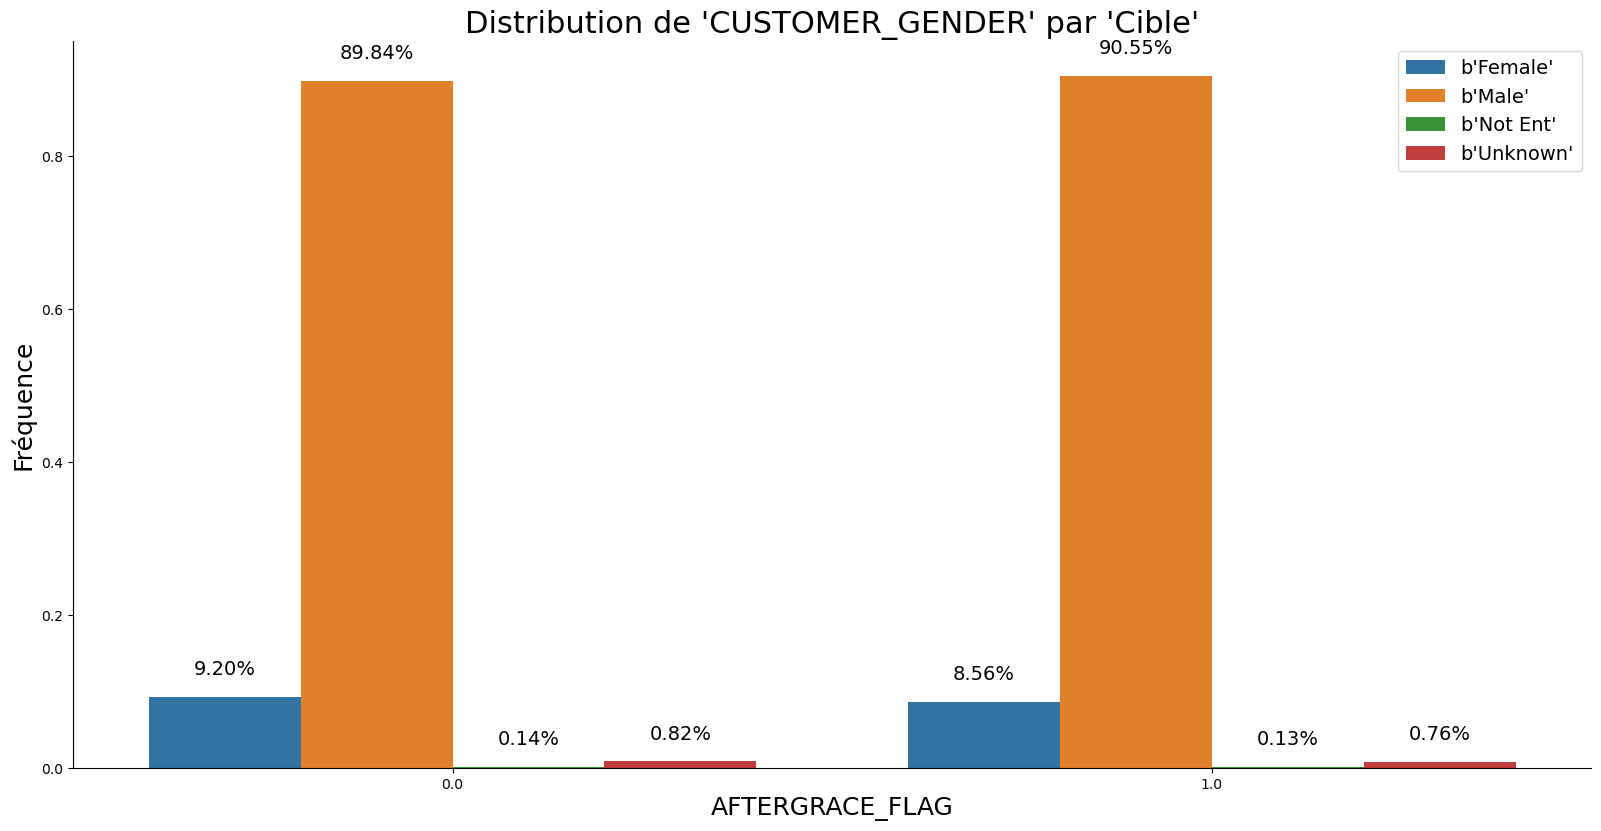

In [ ]:
# Définition d'une fonction pour tracer la distribution d'une variable catégorielle par rapport à la variable cible
def distrib_for_cat_by_target(var_cat: list, dataframe, target: str):
    temp = dataframe.copy()
    temp['Frequency'] = 0
    counts = temp.groupby([target, var_cat]).count()
    freq_per_group = counts.div(counts.groupby(target).transform('sum')).reset_index()
    g = sns.catplot(x=target, y="Frequency", hue=var_cat, data=freq_per_group, kind="bar",
                  height=8, aspect=2, legend=False)
    ax = g.ax
    for p in ax.patches:
        ax.annotate(f"{p.get_height()*100:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=14, color='black', xytext=(0, 20),
                    textcoords='offset points')
    plt.title("Distribution de '" + var_cat + "' par 'Cible'", fontsize=22)
    plt.legend(fontsize=14)
    plt.xlabel(target, fontsize=18)
    plt.ylabel('Fréquence', fontsize=18)
    plt.show()

# Tracer la distribution des variables catégorielles par rapport à la variable
for i in var_cat:
    distrib_for_cat_by_target(i,df,target)


In [ ]:
warnings.filterwarnings("ignore")

# Définition d'une fonction pour tracer la distribution d'une variable numérique par rapport à la variable cible
def distrib_for_num_by_target(var_num: list, dataframe, target: str):
    """
    Fonction de distribution d'une variable explicative selon la variable cible (x|y)
    var_num : variable explicative à étudier
    dataframe
    target : variable cible
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 7))
    sns.distplot(dataframe[dataframe[target] == 0][var_num], ax=ax1)
    sns.distplot(dataframe[dataframe[target] == 1][var_num], ax=ax2)
    ax1.set_title("Distribution de la variable " + var_num + f" \n pour '{target}' = 0")
    ax2.set_title("Distribution de la variable " + var_num + f" \n pour '{target}' = 1")
    plt.show()

# Tracer la distribution des variables numériques par rapport à la variable cible

for i in var_num:
    distrib_for_num_by_target(i, df, target)

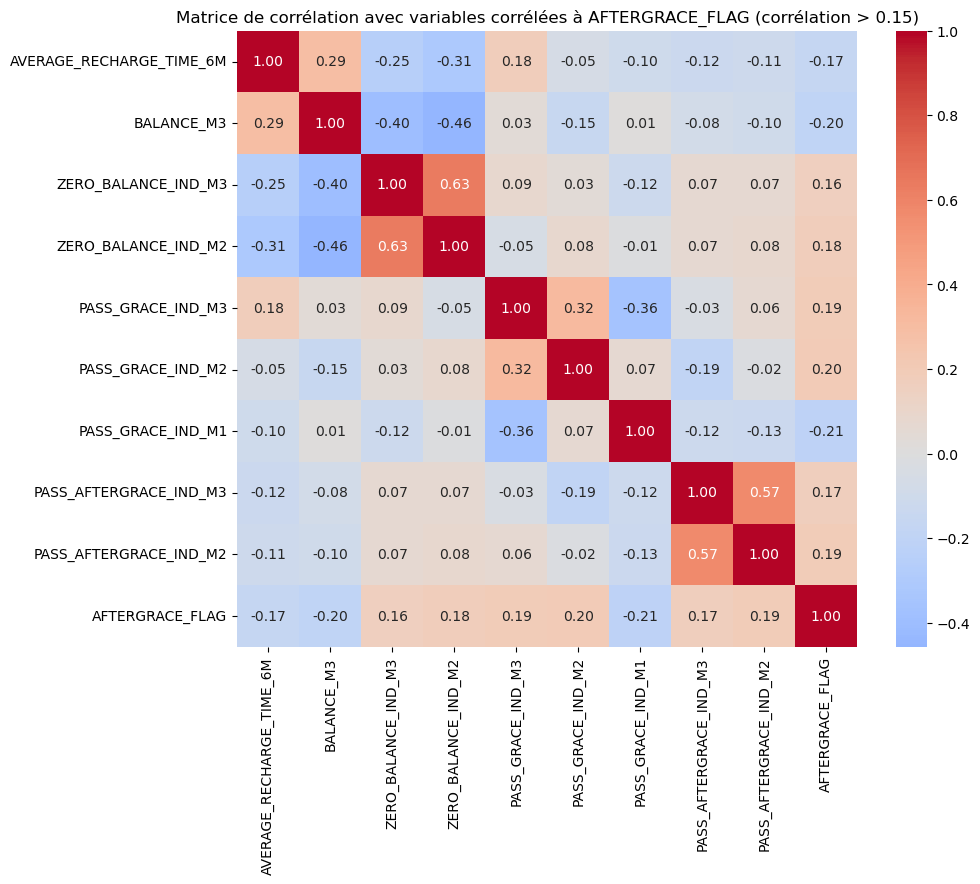

In [ ]:
# Matrice de corrélation
correlation_matrix = df.corr()

# Sélection des variables les plus corrélées à AFTERGRACE_FLAG avec une corrélation supérieure à 0.15
threshold = 0.15
target_correlations = correlation_matrix['AFTERGRACE_FLAG'][(correlation_matrix['AFTERGRACE_FLAG'] > threshold) | (correlation_matrix['AFTERGRACE_FLAG'] < -threshold)]

# Filtrage du DataFrame original pour les variables sélectionnées
filtered_df = df[target_correlations.index]

# Création d'une nouvelle matrice de corrélation avec les variables sélectionnées
filtered_correlation_matrix = filtered_df.corr()

# Création de la heatmap de la matrice de corrélation filtrée
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f", annot_kws={"ha": 'center'})
plt.title("Matrice de corrélation avec variables corrélées à AFTERGRACE_FLAG (corrélation > 0.15)")
plt.show()


<a class="anchor" id="chapter3"></a>
<div style="display: flex; background-color: RGB(119, 150, 203);">
    <h1 style="margin: auto; padding: 30px 30px 30px 30px; color: RGB(255,255,255);">
            <b>Feature engineering</b>
</div>

<a class="anchor" id="section_3_1"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">Création d'indicateur</h3>
</div>

Pour les données d'entraînement :

In [41]:
# les données sont figées à fin M1 (août), M2 = juillet etc jusqu'à M6 = mars

# création de 4 variables (comme on cherche les churners dans les 2 mois)

df_train["FLAG_RECHARGE_M1"] = df_train["RECENCY_OF_LAST_RECHARGE"].apply(lambda x : 1 if 0 <= x <= 31 else 0)

df_train["FLAG_RECHARGE_M2"] = df_train["RECENCY_OF_LAST_RECHARGE"].apply(lambda x : 1 if 32 <= x <= 62 else 0)

df_train["FLAG_RECHARGE_M3"] = df_train["RECENCY_OF_LAST_RECHARGE"].apply(lambda x : 1 if 63 <= x <= 92 else 0)

df_train["FLAG_RECHARGE_PLUS_M3"] = df_train["RECENCY_OF_LAST_RECHARGE"].apply(lambda x : 1 if x >= 93 else 0) #plus loin que M3

In [42]:
# approche via les balances : si balance M2 > M1 et balance M3 > M2 alors il a eu plusieurs recharges sur les 3 mois
# marche que si balance = reste des recharges

for index, row in df_train.iterrows():
    if row["BALANCE_M2"] > row["BALANCE_M1"] and row["BALANCE_M3"] > row["BALANCE_M2"]:
        df_train.at[index, "AVERAGE_MULTIPLE_RECHARGE_M1_M2_M3"] = 1

    else :
        df_train.at[index, "AVERAGE_MULTIPLE_RECHARGE_M1_M2_M3"] = 0

In [43]:
# si quelque chose entre 1 sinon 0

for index, row in df_train.iterrows() :
    if row["INC_DURATION_MINS_M1"] + row["INC_PROP_SMS_CALLS_M1"] == 0 :
        df_train.at[index, "FLAG_IN_M1"] = 0

    else :
        df_train.at[index, "FLAG_IN_M1"] = 1

    if row["INC_DURATION_MINS_M2"] + row["INC_PROP_SMS_CALLS_M2"] == 0 :
        df_train.at[index, "FLAG_IN_M2"] = 0

    else :
        df_train.at[index, "FLAG_IN_M2"] = 1

    if row["INC_DURATION_MINS_M3"] + row["INC_PROP_SMS_CALLS_M3"] == 0 :
        df_train.at[index, "FLAG_IN_M3"] = 0

    else :
        df_train.at[index, "FLAG_IN_M3"] = 1

In [44]:
# si quelque chose sort 1 sinon 0

for index, row in df_train.iterrows() :
    if row["OUT_DURATION_MINS_M1"] + row["OUT_SMS_NO_M1"] + row["OUT_INT_DURATION_MINS_M1"] + row["OUT_888_DURATION_MINS_M1"] + row["OUT_VMACC_NO_CALLS_M1"] == 0:
        df_train.at[index, "FLAG_OUT_M1"] = 0

    else :
        df_train.at[index, "FLAG_OUT_M1"] = 1

    if row["OUT_DURATION_MINS_M2"] + row["OUT_SMS_NO_M2"] + row["OUT_INT_DURATION_MINS_M2"] == 0 + row["OUT_888_DURATION_MINS_M2"] + row["OUT_VMACC_NO_CALLS_M2"] == 0 :
        df_train.at[index, "FLAG_OUT_M2"] = 0

    else :
        df_train.at[index, "FLAG_OUT_M2"] = 1

    if row["OUT_DURATION_MINS_M3"] + row["OUT_SMS_NO_M3"] + row["OUT_INT_DURATION_MINS_M3"] + row["OUT_888_DURATION_MINS_M3"] + row["OUT_VMACC_NO_CALLS_M3"] == 0 :
        df_train.at[index, "FLAG_OUT_M3"] = 0

    else :

        df_train.at[index, "FLAG_OUT_M3"] = 1

In [45]:
# type de contrat : ancien ou nouveau (règle : si supérieur à 2 ans vieux sinon nouveau)


for index, row in df_train.iterrows() :
    if row["CONTRACT_TENURE_DAYS"] > 730 :
        df_train.at[index, "OLD_CONTRACT"] = 1

    else :
        df_train.at[index,"OLD_CONTRACT"] = 0

Pour les données de test/validation

In [46]:
# les données sont figées à fin M1 (août), M2 = juillet etc jusqu'à M6 = mars

# création de 4 variables (comme on cherche les churners dans les 2 mois)

df_val["FLAG_RECHARGE_M1"] = df_val["RECENCY_OF_LAST_RECHARGE"].apply(lambda x : 1 if 0 <= x <= 31 else 0)

df_val["FLAG_RECHARGE_M2"] = df_val["RECENCY_OF_LAST_RECHARGE"].apply(lambda x : 1 if 32 <= x <= 62 else 0)

df_val["FLAG_RECHARGE_M3"] = df_val["RECENCY_OF_LAST_RECHARGE"].apply(lambda x : 1 if 63 <= x <= 92 else 0)

df_val["FLAG_RECHARGE_PLUS_M3"] = df_val["RECENCY_OF_LAST_RECHARGE"].apply(lambda x : 1 if x >= 93 else 0) #plus loin que M3

In [47]:
# approche via les balances : si balance M1 > M2 ou balance M2 > M3 ou balance M1 > M3 alors il a eu plusieurs recharges sur les 3 mois
# marche que si balance = reste des recharges

for index, row in df_val.iterrows():
    if row["BALANCE_M2"] > row["BALANCE_M1"] and row["BALANCE_M3"] > row["BALANCE_M2"]:
        df_val.at[index, "AVERAGE_MULTIPLE_RECHARGE_M1_M2_M3"] = 1

    else :
        df_val.at[index, "AVERAGE_MULTIPLE_RECHARGE_M1_M2_M3"] = 0

In [48]:
# si quelque chose entre 1 sinon 0

for index, row in df_val.iterrows() :
    if row["INC_DURATION_MINS_M1"] + row["INC_PROP_SMS_CALLS_M1"] == 0 :
        df_val.at[index, "FLAG_IN_M1"] = 0

    else :
        df_val.at[index, "FLAG_IN_M1"] = 1

    if row["INC_DURATION_MINS_M2"] + row["INC_PROP_SMS_CALLS_M2"] == 0 :
        df_val.at[index, "FLAG_IN_M2"] = 0

    else :
        df_val.at[index, "FLAG_IN_M2"] = 1

    if row["INC_DURATION_MINS_M3"] + row["INC_PROP_SMS_CALLS_M3"] == 0 :
        df_val.at[index, "FLAG_IN_M3"] = 0

    else :
        df_val.at[index, "FLAG_IN_M3"] = 1

In [49]:
# si quelque chose sort 1 sinon 0

for index, row in df_val.iterrows() :
    if row["OUT_DURATION_MINS_M1"] + row["OUT_SMS_NO_M1"] + row["OUT_INT_DURATION_MINS_M1"] + row["OUT_888_DURATION_MINS_M1"] + row["OUT_VMACC_NO_CALLS_M1"] == 0:
        df_val.at[index, "FLAG_OUT_M1"] = 0

    else :
        df_val.at[index, "FLAG_OUT_M1"] = 1

    if row["OUT_DURATION_MINS_M2"] + row["OUT_SMS_NO_M2"] + row["OUT_INT_DURATION_MINS_M2"] + row["OUT_888_DURATION_MINS_M2"] + row["OUT_VMACC_NO_CALLS_M2"] == 0 :
        df_val.at[index, "FLAG_OUT_M2"] = 0

    else :
        df_val.at[index, "FLAG_OUT_M2"] = 1

    if row["OUT_DURATION_MINS_M3"] + row["OUT_SMS_NO_M3"] + row["OUT_INT_DURATION_MINS_M3"] + row["OUT_888_DURATION_MINS_M3"] + row["OUT_VMACC_NO_CALLS_M3"] == 0 :
        df_val.at[index, "FLAG_OUT_M3"] = 0

    else :

        df_val.at[index, "FLAG_OUT_M3"] = 1

In [50]:
# type de contrat : ancien ou nouveau (règle : si supérieur à 2 ans vieux sinon nouveau)

for index, row in df_val.iterrows() :
    if row["CONTRACT_TENURE_DAYS"] > 730 :
        df_val.at[index, "OLD_CONTRACT"] = 1

    else :
        df_val.at[index, "OLD_CONTRACT"] = 0

<a class="anchor" id="section_3_2"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">Pré-sélection des variables (Chi 2 et Student)</h3>
</div>

In [51]:
# Variables catégortielles test du Chi 2:
info_types = pd.DataFrame(df_train.dtypes)
list_var_cat = info_types[info_types[0]=="object"].index.tolist()
list_col_to_drop = []

target = "AFTERGRACE_FLAG"
for v in list_var_cat:
    if v!=target:
        cont = df_train[[v, target]].pivot_table(index=v, columns=target, aggfunc=len).fillna(0).copy().astype(int) # Création de la table de contingence
        st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(cont)

        #col to drop :
        if st_p >= 0.05 :
            list_col_to_drop.append(v)

        #print(v + ": p-value test chi 2 = " + str(st_p))

In [52]:
info_df_num = df_train.describe()

for v in info_df_num.columns.tolist():
    if v!= target:
        a=list(df_train[df_train[target]==0][v])
        b=list(df_train[df_train[target]==1][v])
        st_test, st_p = st.ttest_ind(a, b, axis=0, equal_var=False, nan_policy='omit')

        #col to drop :
        if st_p >= 0.05 :
            list_col_to_drop.append(v)

        #print(v + ": p-value test Student = " + str(st_p))

In [53]:
list_col_to_drop

['PASS_AFTERGRACE_IND_M1',
 'INC_DURATION_MINS_M1',
 'INC_PROP_OPE2_MIN_M3',
 'OUT_DURATION_MINS_M1',
 'OUT_DURATION_MINS_M3',
 'OUT_INT_DURATION_MINS_M3',
 'OUT_VMACC_NO_CALLS_M1',
 'INC_OUT_PROP_DUR_MIN_M1']

In [54]:
df_train.drop(list_col_to_drop, axis=1, inplace=True)
df_val.drop(list_col_to_drop, axis=1, inplace=True)

<a class="anchor" id="section_3_3"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">Encoding et scaling (train et validation set)</h3>
</div>

In [55]:
x_train = df_train.drop([target], axis=1)
y_train = df_train[target]

x_val = df_val.drop([target], axis=1)
y_val = df_val[target]

In [56]:
x_train

,CUSTOMER_AGE,CUSTOMER_GENDER,CONTRACT_TENURE_DAYS,AVERAGE_CHARGE_6M,FAILED_RECHARGE_6M,AVERAGE_RECHARGE_TIME_6M,BALANCE_M3,BALANCE_M2,BALANCE_M1,FIRST_RECHARGE_VALUE,LAST_RECHARGE_VALUE,TIME_TO_GRACE,TIME_TO_AFTERGRACE,RECENCY_OF_LAST_RECHARGE,TOTAL_RECHARGE_6M,NO_OF_RECHARGES_6M,ZERO_BALANCE_IND_M3,ZERO_BALANCE_IND_M2,ZERO_BALANCE_IND_M1,PASS_GRACE_IND_M3,PASS_GRACE_IND_M2,PASS_GRACE_IND_M1,PASS_AFTERGRACE_IND_M3,PASS_AFTERGRACE_IND_M2,DATA_FLAG,INT_FLAG,ROAM_FLAG,NUM_HANDSET_USED_6M,INC_DURATION_MINS_M2,INC_DURATION_MINS_M3,INC_PROP_SMS_CALLS_M1,INC_PROP_SMS_CALLS_M2,INC_PROP_SMS_CALLS_M3,INC_PROP_OPE1__MIN_M1,INC_PROP_OPE1__MIN_M2,INC_PROP_OPE1__MIN_M3,INC_PROP_OPE2_MIN_M1,INC_PROP_OPE2_MIN_M2,INC_PROP_FIXED_MIN_M1,INC_PROP_FIXED_MIN_M2,INC_PROP_FIXED_MIN_M3,OUT_DURATION_MINS_M2,OUT_SMS_NO_M1,OUT_SMS_NO_M2,OUT_SMS_NO_M3,OUT_INT_DURATION_MINS_M1,OUT_INT_DURATION_MINS_M2,OUT_888_DURATION_MINS_M1,OUT_888_DURATION_MINS_M2,OUT_888_DURATION_MINS_M3,OUT_VMACC_NO_CALLS_M2,OUT_VMACC_NO_CALLS_M3,OUT_PROP_SMS_CALLS_M1,OUT_PROP_SMS_CALLS_M2,OUT_PROP_SMS_CALLS_M3,OUT_PROP_OPE1__MIN_M1,OUT_PROP_OPE1__MIN_M2,OUT_PROP_OPE1__MIN_M3,OUT_PROP_OPE2_MIN_M1,OUT_PROP_OPE2_MIN_M2,OUT_PROP_OPE2_MIN_M3,OUT_PROP_FIXED_MIN_M1,OUT_PROP_FIXED_MIN_M2,OUT_PROP_FIXED_MIN_M3,INC_OUT_PROP_DUR_MIN_M2,INC_OUT_PROP_DUR_MIN_M3,marque,FLAG_RECHARGE_M1,FLAG_RECHARGE_M2,FLAG_RECHARGE_M3,FLAG_RECHARGE_PLUS_M3,AVERAGE_MULTIPLE_RECHARGE_M1_M2_M3,FLAG_IN_M1,FLAG_IN_M2,FLAG_IN_M3,FLAG_OUT_M1,FLAG_OUT_M2,FLAG_OUT_M3,OLD_CONTRACT
0,99.0,male,1088.0,58.33,0.0,42.0,7.65,148.05,148.05,100.0,200.0,-62.0,-122.0,58.0,350.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,38.0,96.0,0.00,0.03,0.00,0.00,0.00,0.02,0.00,0.53,0.00,0.47,0.53,33.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.00,0.10,0.10,0.00,0.00,0.23,0.00,0.52,0.19,0.00,0.27,0.44,1.15,1.09,nokia,0,1,0,0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1,22.0,male,833.0,54.17,3.0,119.0,4.00,0.00,83.50,100.0,100.0,28.0,-2.0,118.0,100.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4.0,238.0,237.0,0.02,0.00,0.03,0.50,0.38,0.36,0.30,0.49,0.21,0.13,0.13,4.0,0.0,2.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.50,1.58,0.00,0.00,0.42,0.00,0.50,0.17,0.00,0.00,0.17,59.50,19.75,nokia,0,0,0,1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,52.0,male,743.0,41.67,2.0,42.0,44.90,0.00,66.50,25.0,100.0,-77.0,-107.0,13.0,250.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,64.0,357.0,0.00,0.03,0.00,0.33,0.16,0.06,0.00,0.08,0.61,0.69,0.89,43.0,3.0,8.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.10,0.20,0.09,0.24,0.49,0.38,0.00,0.00,0.00,0.00,0.02,0.28,1.49,8.93,nokia,1,0,0,0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,46.0,male,304.0,16.67,1.0,79.0,2.05,0.75,0.25,100.0,100.0,-50.0,-80.0,40.0,200.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,60.0,57.0,0.02,0.04,0.05,0.53,0.32,0.40,0.41,0.53,0.05,0.13,0.12,19.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.07,0.07,0.00,0.00,0.00,0.00,0.21,0.00,0.00,0.00,0.00,3.16,57.00,nokia,0,1,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,26.0,male,1532.0,16.67,0.0,120.0,288.36,240.06,185.36,100.0,100.0,-4.0,-34.0,86.0,100.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,44.0,60.0,0.15,0.09,0.26,0.12,0.32,0.18,0.48,0.23,0.40,0.45,0.28,21.0,75.0,51.0,46.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,12.50,3.92,3.83,0.09,0.62,0.68,0.64,0.00,0.14,0.00,0.00,0.00,2.10,2.73,nokia,0,0,1,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39238,99.0,male,418.0,16.67,0.0,145.0,0.25,67.15,5.15,50.0,100.0,-37.0,-67.0,53.0,200.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,53.0,47.0,0.00,0.00,0.17,0.67,0.66,0.81,0.20,0.25,0.13,0.09,0.09,16.0,35.0,4.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,1.59,0.29,0.00,0.33,0.50,0.00,0.03,0.00,0.00,0.00,0.06,0.00,3.31,47.00,nokia,0,1,0,0,0.

In [57]:
#numeric and > 2 :
list_cont_col = x_train.select_dtypes(include=[np.number]).columns.tolist()
list_cont_col = [col for col in list_cont_col if x_train[col].nunique() > 2]
len(list_cont_col)

54

In [58]:
#numeric and <= 2 :
list_binary_col = x_train.select_dtypes(include=[np.number]).columns.tolist()
list_binary_col = [col for col in list_binary_col if x_train[col].nunique() <= 2]
len(list_binary_col)

23

In [59]:
#categorical col :
#list_cat_col = x_train.select_dtypes(include=['object']).columns.tolist()
list_cat_col_OHE = ['CUSTOMER_GENDER']
list_cat_col_TE =  ['marque']

In [60]:
len(list_cont_col) + len(list_binary_col) + len(list_cat_col_OHE) + len(list_cat_col_TE)

79

In [61]:
sys.path.append("./pre_processing.py")
a = pre_processing()

In [62]:
#Pre processing for linear models :
#for boosting, we encode all variable.
x_train_bis = x_train.copy() #utilisé plus tard

x_train_preprocessed = a.pre_processing(df=x_train, train=True, categorical_var_OHE= list_cat_col_OHE,
                           categorical_var_OrdinalEncoding={}, categorical_var_TE=list_cat_col_TE, target=y_train,
                           continious_var=list_cont_col, encoding_type_cont=MinMaxScaler())
x_train_preprocessed

,CUSTOMER_AGE,CONTRACT_TENURE_DAYS,AVERAGE_CHARGE_6M,FAILED_RECHARGE_6M,AVERAGE_RECHARGE_TIME_6M,BALANCE_M3,BALANCE_M2,BALANCE_M1,FIRST_RECHARGE_VALUE,LAST_RECHARGE_VALUE,TIME_TO_GRACE,TIME_TO_AFTERGRACE,RECENCY_OF_LAST_RECHARGE,TOTAL_RECHARGE_6M,NO_OF_RECHARGES_6M,ZERO_BALANCE_IND_M3,ZERO_BALANCE_IND_M2,ZERO_BALANCE_IND_M1,PASS_GRACE_IND_M3,PASS_GRACE_IND_M2,PASS_GRACE_IND_M1,PASS_AFTERGRACE_IND_M3,PASS_AFTERGRACE_IND_M2,DATA_FLAG,INT_FLAG,ROAM_FLAG,NUM_HANDSET_USED_6M,INC_DURATION_MINS_M2,INC_DURATION_MINS_M3,INC_PROP_SMS_CALLS_M1,INC_PROP_SMS_CALLS_M2,INC_PROP_SMS_CALLS_M3,INC_PROP_OPE1__MIN_M1,INC_PROP_OPE1__MIN_M2,INC_PROP_OPE1__MIN_M3,INC_PROP_OPE2_MIN_M1,INC_PROP_OPE2_MIN_M2,INC_PROP_FIXED_MIN_M1,INC_PROP_FIXED_MIN_M2,INC_PROP_FIXED_MIN_M3,OUT_DURATION_MINS_M2,OUT_SMS_NO_M1,OUT_SMS_NO_M2,OUT_SMS_NO_M3,OUT_INT_DURATION_MINS_M1,OUT_INT_DURATION_MINS_M2,OUT_888_DURATION_MINS_M1,OUT_888_DURATION_MINS_M2,OUT_888_DURATION_MINS_M3,OUT_VMACC_NO_CALLS_M2,OUT_VMACC_NO_CALLS_M3,OUT_PROP_SMS_CALLS_M1,OUT_PROP_SMS_CALLS_M2,OUT_PROP_SMS_CALLS_M3,OUT_PROP_OPE1__MIN_M1,OUT_PROP_OPE1__MIN_M2,OUT_PROP_OPE1__MIN_M3,OUT_PROP_OPE2_MIN_M1,OUT_PROP_OPE2_MIN_M2,OUT_PROP_OPE2_MIN_M3,OUT_PROP_FIXED_MIN_M1,OUT_PROP_FIXED_MIN_M2,OUT_PROP_FIXED_MIN_M3,INC_OUT_PROP_DUR_MIN_M2,INC_OUT_PROP_DUR_MIN_M3,FLAG_RECHARGE_M1,FLAG_RECHARGE_M2,FLAG_RECHARGE_M3,FLAG_RECHARGE_PLUS_M3,AVERAGE_MULTIPLE_RECHARGE_M1_M2_M3,FLAG_IN_M1,FLAG_IN_M2,FLAG_IN_M3,FLAG_OUT_M1,FLAG_OUT_M2,FLAG_OUT_M3,OLD_CONTRACT,CUSTOMER_GENDER_male,CUSTOMER_GENDER_nan,marque
0,1.000000,0.598027,0.028369,0.000000,0.194444,0.006054,0.117314,0.112688,0.428571,1.000000,0.198582,0.167164,0.235537,0.027088,0.009259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.021277,0.007819,0.016296,0.000000,0.000970,0.000000,0.00,0.00,0.02,0.00,0.53,0.00,0.47,0.53,0.010873,0.000000,0.005618,0.008942,0.000000,0.0,0.0,0.000000,0.016667,0.000000,0.000000,0.000000,0.000546,0.000537,0.00,0.00,0.23,0.00,0.52,0.19,0.00,0.27,0.44,0.000397,0.000434,0,1,0,0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.348770
1,0.049383,0.440814,0.026009,0.081081,0.550926,0.003165,0.000000,0.063556,0.428571,0.428571,0.517730,0.525373,0.483471,0.004515,0.004630,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.015957,0.048971,0.040231,0.001235,0.000000,0.001765,0.50,0.38,0.36,0.30,0.49,0.21,0.13,0.13,0.001318,0.000000,0.003745,0.028316,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.002732,0.008480,0.00,0.00,0.42,0.00,0.50,0.17,0.00,0.00,0.17,0.020553,0.007865,0,0,0,1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.348770
2,0.419753,0.385327,0.018916,0.054054,0.194444,0.035531,0.000000,0.050617,0.000000,0.428571,0.145390,0.211940,0.049587,0.018059,0.009259,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.015957,0.013169,0.060601,0.000000,0.000970,0.000000,0.33,0.16,0.06,0.00,0.08,0.61,0.69,0.89,0.014168,0.003881,0.014981,0.004471,0.000000,0.0,0.0,0.000000,0.000000,0.002457,0.000000,0.000685,0.001093,0.000483,0.24,0.49,0.38,0.00,0.00,0.00,0.00,0.02,0.28,0.000515,0.003556,1,0,0,0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.348770
3,0.345679,0.114673,0.004732,0.027027,0.365741,0.001622,0.000594,0.000190,0.428571,0.428571,0.241135,0.292537,0.161157,0.013544,0.004630,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.010638,0.012346,0.009676,0.001235,0.001294,0.002941,0.53,0.32,0.40,0.41,0.53,0.05,0.13,0.12,0.006260,0.001294,0.001873,0.001490,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000274,0.000383,0.000376,0.00,0.00,0.00,0.00,0.21,0.00,0.00,0.00,0.00,0.001092,0.022700,0,1,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.348770
4,0.098765,0.871763,0.004732,0.000000,0.555556,0.228187,0.190222,0.141087,0.428571,0.428571,0.404255,0.429851,0.351240,0.004515,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.005319,0.009053,0.010185,0.009265,0.002911,0.015294,0.12,0.32,0.18,0.48,0.23,0.40,0.45,0.28,0.006919,0.097025,0.095506,0.068554,0.004773,0.0,0.0,0.010695,0.000000,0.000000,0.000000,0.085616,0.021421,0.020555,0.09,0.62,0.68,0.64,0.00,0.14

In [63]:
x_val_bis = x_val.copy() #utilisé plus tard

x_val_preprocessed = a.pre_processing(df=x_val, train=False, categorical_var_OHE= list_cat_col_OHE,
                         categorical_var_OrdinalEncoding={}, categorical_var_TE=list_cat_col_TE, target=y_train,
                         continious_var=list_cont_col, encoding_type_cont=MinMaxScaler())
x_val_preprocessed

,CUSTOMER_AGE,CONTRACT_TENURE_DAYS,AVERAGE_CHARGE_6M,FAILED_RECHARGE_6M,AVERAGE_RECHARGE_TIME_6M,BALANCE_M3,BALANCE_M2,BALANCE_M1,FIRST_RECHARGE_VALUE,LAST_RECHARGE_VALUE,TIME_TO_GRACE,TIME_TO_AFTERGRACE,RECENCY_OF_LAST_RECHARGE,TOTAL_RECHARGE_6M,NO_OF_RECHARGES_6M,ZERO_BALANCE_IND_M3,ZERO_BALANCE_IND_M2,ZERO_BALANCE_IND_M1,PASS_GRACE_IND_M3,PASS_GRACE_IND_M2,PASS_GRACE_IND_M1,PASS_AFTERGRACE_IND_M3,PASS_AFTERGRACE_IND_M2,DATA_FLAG,INT_FLAG,ROAM_FLAG,NUM_HANDSET_USED_6M,INC_DURATION_MINS_M2,INC_DURATION_MINS_M3,INC_PROP_SMS_CALLS_M1,INC_PROP_SMS_CALLS_M2,INC_PROP_SMS_CALLS_M3,INC_PROP_OPE1__MIN_M1,INC_PROP_OPE1__MIN_M2,INC_PROP_OPE1__MIN_M3,INC_PROP_OPE2_MIN_M1,INC_PROP_OPE2_MIN_M2,INC_PROP_FIXED_MIN_M1,INC_PROP_FIXED_MIN_M2,INC_PROP_FIXED_MIN_M3,OUT_DURATION_MINS_M2,OUT_SMS_NO_M1,OUT_SMS_NO_M2,OUT_SMS_NO_M3,OUT_INT_DURATION_MINS_M1,OUT_INT_DURATION_MINS_M2,OUT_888_DURATION_MINS_M1,OUT_888_DURATION_MINS_M2,OUT_888_DURATION_MINS_M3,OUT_VMACC_NO_CALLS_M2,OUT_VMACC_NO_CALLS_M3,OUT_PROP_SMS_CALLS_M1,OUT_PROP_SMS_CALLS_M2,OUT_PROP_SMS_CALLS_M3,OUT_PROP_OPE1__MIN_M1,OUT_PROP_OPE1__MIN_M2,OUT_PROP_OPE1__MIN_M3,OUT_PROP_OPE2_MIN_M1,OUT_PROP_OPE2_MIN_M2,OUT_PROP_OPE2_MIN_M3,OUT_PROP_FIXED_MIN_M1,OUT_PROP_FIXED_MIN_M2,OUT_PROP_FIXED_MIN_M3,INC_OUT_PROP_DUR_MIN_M2,INC_OUT_PROP_DUR_MIN_M3,FLAG_RECHARGE_M1,FLAG_RECHARGE_M2,FLAG_RECHARGE_M3,FLAG_RECHARGE_PLUS_M3,AVERAGE_MULTIPLE_RECHARGE_M1_M2_M3,FLAG_IN_M1,FLAG_IN_M2,FLAG_IN_M3,FLAG_OUT_M1,FLAG_OUT_M2,FLAG_OUT_M3,OLD_CONTRACT,CUSTOMER_GENDER_male,CUSTOMER_GENDER_nan,marque
0,0.098765,0.644883,0.014184,0.000000,0.421296,0.039606,0.082845,0.057924,0.428571,0.428571,0.248227,0.298507,0.169421,0.013544,0.004630,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.159574,0.052881,0.035138,0.008647,0.002911,0.002353,0.15,0.20,0.22,0.47,0.58,0.38,0.23,0.45,0.008896,0.012937,0.050562,0.035768,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.003425,0.009836,0.018408,0.65,0.85,0.57,0.00,0.00,0.14,0.03,0.07,0.00,0.003288,0.011776,0,1,0,0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.320346
1,1.000000,0.475956,0.014184,0.054054,0.425926,0.032880,0.009311,0.000799,0.142857,0.428571,0.287234,0.331343,0.214876,0.022573,0.009259,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.042553,0.161317,0.124597,0.000000,0.000000,0.000588,0.12,0.07,0.10,0.23,0.13,0.32,0.22,0.29,0.021417,0.000000,0.000000,0.000000,0.000000,0.011211,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.08,0.45,0.42,0.38,0.32,0.36,0.31,0.05,0.06,0.004166,0.008120,0,1,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.379456
2,0.074074,0.469790,0.018916,0.000000,0.185185,0.011237,0.019810,0.028315,0.000000,0.142857,0.365248,0.456716,0.057851,0.018059,0.018519,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.047872,0.015432,0.016466,0.003706,0.006468,0.005882,0.57,0.88,0.51,0.37,0.04,0.05,0.00,0.08,0.010873,0.001294,0.005618,0.007452,0.004773,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000274,0.000656,0.001073,0.31,0.70,0.41,0.07,0.06,0.19,0.24,0.00,0.00,0.000784,0.001430,1,0,0,0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.320346
3,0.259259,0.358816,0.004732,0.000000,0.550926,0.098125,0.070285,0.009134,0.428571,0.428571,0.407801,0.432836,0.355372,0.004515,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.037234,0.001852,0.000679,0.000000,0.000000,0.014706,0.33,0.78,0.75,0.33,0.11,0.33,0.11,0.00,0.007908,0.003881,0.011236,0.014903,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000548,0.001639,0.003166,0.00,0.21,0.00,0.05,0.63,0.35,0.42,0.00,0.00,0.000131,0.000096,0,0,1,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.348770
4,0.012346,0.440814,0.016550,0.000000,0.157407,0.000000,0.004635,0.015299,0.142857,0.000000,0.393617,0.495522,0.008264,0.013544,0.018519,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.037234,0.017695,0.014259,0.001853,0.002911,0.007647,0.42,0.13,0.23,0.25,0.56,0.33,0.31,0.30,0.004613,0.010349,0.003745,0.005961,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.004589,0.000929,0.005367,0.08,0.07,0.00,0.00,0.14,0.00,0.08,0.29,0.00,0.002121,0.008363,1,0,0,0,0.0,1.0,

In [ ]:
#Pre processing for boosting models :
#for boosting, we only encode categorical variable.
x_train = a.pre_processing(df=x_train, train=True, categorical_var_OHE= list_cat_col_OHE,
                           categorical_var_OrdinalEncoding={}, categorical_var_TE=list_cat_col_TE, target=y_train,
                           continious_var=[], encoding_type_cont=StandardScaler())
x_train

,stars,reviews,superhost,traveler,room,bed,bathroom,free_parking_on_site,free_street_parking,private_entrance,heating,smoke_detector,access_sea,seaview,kitchen,washing_machine,dryer,AC,wifi,accepted_animals,tv,fridge,freezer,oven,microwave_oven,basic_kitchen_equipment,dishwasher,smoker,backyard,workspace,private_garden,patio_or_balcony,swimming_pool,surface,transport_access,location
0,4.780,82.0,0.0,4,1.0,1,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,60.0,0.0,199.867269
1,4.845,0.0,0.0,6,3.0,5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,99.0,0.0,214.274829
2,4.845,2.0,0.0,6,3.0,3,2.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1,99.0,0.0,214.274829
3,5.000,3.0,0.0,9,5.0,8,3.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,99.0,0.0,214.274829
4,4.670,38.0,0.0,2,1.0,1,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,99.0,1.0,196.060119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,4.740,55.0,0.0,3,1.0,2,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0,99.0,1.0,214.274829
221,4.860,7.0,0.0,8,4.0,5,3.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,99.0,0.0,253.474963
222,4.750,4.0,0.0,4,2.0,3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0,60.0,0.0,214.274829
223,4.845,0.0,0.0,2,1.0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,99.0,1.0,214.274829


In [ ]:
x_val = a.pre_processing(df=x_val, train=False, categorical_var_OHE= list_cat_col_OHE,
                         categorical_var_OrdinalEncoding={}, categorical_var_TE=list_cat_col_TE, target=y_train,
                         continious_var=[], encoding_type_cont=StandardScaler())
x_val

,stars,reviews,superhost,traveler,room,bed,bathroom,free_parking_on_site,free_street_parking,private_entrance,heating,smoke_detector,access_sea,seaview,kitchen,washing_machine,dryer,AC,wifi,accepted_animals,tv,fridge,freezer,oven,microwave_oven,basic_kitchen_equipment,dishwasher,smoker,backyard,workspace,private_garden,patio_or_balcony,swimming_pool,surface,transport_access,location
0,4.845,0.0,0.0,6,2.0,2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,99.0,0.0,215.435556
1,4.710,28.0,0.0,10,4.0,5,1.5,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0,99.0,0.0,214.274829
2,4.845,0.0,0.0,6,3.0,4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,115.0,0.0,253.474963
3,4.000,4.0,0.0,5,3.0,4,2.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1,130.0,0.0,199.867269
4,4.920,12.0,1.0,6,2.0,3,2.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0,99.0,1.0,208.222920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,4.845,0.0,0.0,4,1.0,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,99.0,0.0,197.260628
71,4.820,23.0,0.0,5,2.0,3,2.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1,110.0,0.0,198.464784
72,4.670,6.0,0.0,5,4.0,4,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1,99.0,1.0,214.274829
73,4.680,37.0,1.0,2,1.0,1,1.5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0,99.0,1.0,196.931510


<a class="anchor" id="section_3_4"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">Sélection des variables - Regression logistique (RFE)</h3>
</div>

In [ ]:
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

rfe_score = {"nb_var" : 0,
             "best_score" : 0}

for i in tqdm(range(1,len(x_train_preprocessed.columns)+1)) :
    estimator = LogisticRegression(penalty=None)
    selector = RFE(estimator, n_features_to_select=i,step=1)
    selector.fit(x_train_preprocessed,y_train)

    x_train_preprocessed_new = x_train_preprocessed[list(selector.get_feature_names_out())]
    estimator.fit(x_train_preprocessed_new,y_train)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
    skf.get_n_splits(x_train_preprocessed_new, y_train)    
    cross_val_score_ = mean(cross_val_score(estimator, x_train_preprocessed_new, y_train, cv=skf, scoring = "roc_auc")) #scoring : replace accuracy by recall or roc_auc

    if cross_val_score_ > rfe_score["best_score"] :
        rfe_score["nb_var"] = i
        rfe_score["best_score"] = cross_val_score_

In [ ]:
rfe_score

In [ ]:
warnings.filterwarnings('ignore')

estimator = LogisticRegression()
selector = RFE(estimator, n_features_to_select=rfe_score['nb_var'], step=1)
selector.fit(x_train_preprocessed,y_train)

print(list(selector.get_feature_names_out()))

In [ ]:
# Linear model :
x_train_preprocessed = x_train_preprocessed[list(selector.get_feature_names_out())]
x_val_preprocessed = x_val_preprocessed[list(selector.get_feature_names_out())]

# Boosting model :
x_train = x_train[list(selector.get_feature_names_out())]
x_val = x_val[list(selector.get_feature_names_out())]

x_train

<a class="anchor" id="chapter4"></a>
<div style="display: flex; background-color: RGB(119, 150, 203);">
    <h1 style="margin: auto; padding: 30px 30px 30px 30px; color: RGB(255,255,255);">
            <b>Modélisation</b>
</div>

<a class="anchor" id="section_4_1"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">Régression logistique</h3>
</div>

### Modélisation naïve

In [ ]:
lr = LogisticRegression(penalty="none")
lr.fit(x_train_preprocessed, y_train)
print(lr.score(x_train_preprocessed, y_train)) # replace scoring='accuracy' by "recall"  #or roc_auc
print(lr.score(x_val_preprocessed, y_val)) # replace scoring='accuracy' by "recall"  #or roc_auc

0.7486940346048977
0.7472236372898624


In [ ]:
#get roc auc score : (or recall)

print(roc_auc_score(y_train, lr.predict_proba(x_train_preprocessed)[:, 1])) #, multi_class='ovr'
print(roc_auc_score(y_val, lr.predict_proba(x_val_preprocessed)[:, 1])) #, multi_class='ovr'

0.8186161298457959
0.8163288248246554


Diff metrics (scoring) : accuracy, average_precision, precision, recall, f1(for binary targets) , roc_auc

In [ ]:
print(cross_val_score(lr, x_train_preprocessed,y_train, cv=5, scoring = "roc_auc").mean()) # replace scoring='accuracy' by "recall"  #or roc_auc
print(cross_val_score(lr, x_val_preprocessed,y_val, cv=5, scoring='accuracy').mean())
print(cross_val_score(lr, x_val_preprocessed,y_val, cv=5, scoring='f1_weighted').mean())

0.8188937165506364


In [ ]:
#cross_val_score stratifié : better than Classic Cross_val_score
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
skf.get_n_splits(x_train_preprocessed, y_train)

print(cross_val_score(model, x_train_preprocessed, y_train, cv=skf, scoring='roc_auc').mean())

### Optimisation des hyperparamètres

penalty = {‘l1’, ‘l2’, ‘elasticnet’, None}
C = float, default=1.0
class_weight= None or ‘balanced’, default=None
solver = {‘saga’}, default=’lbfgs’
max_iter = int, default=100
l1_ratio = float, default=None

In [ ]:
# Bayesian Optimisation (optuna) :
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

def objective(trial):
    penalty = trial.suggest_categorical('penalty', ["l1", "l2", "elasticnet", "none"])
    C = trial.suggest_float('C', 0.1, 5) #, step=0.1
    class_weight = trial.suggest_categorical('class_weight', ["balanced", None])
    max_iter = trial.suggest_int('max_iter', 1, 500)
    l1_ratio = trial.suggest_float('l1_ratio', 0.001, 0.999)

    model = LogisticRegression(solver='saga', penalty=penalty, C=C, class_weight=class_weight, max_iter=max_iter, l1_ratio=l1_ratio)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
    skf.get_n_splits(x_train_preprocessed, y_train) 
    return cross_val_score(model, x_train_preprocessed, y_train, n_jobs=-1, cv=skf, scoring='roc_auc').mean() # replace scoring='accuracy' by "recall"  #or auc


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [ ]:
trial = study.best_trial
print('accuracy: {}'.format(trial.value)) # replace scoring='accuracy' by "recall"  #or auc
print("Best hyperparameters: {}".format(trial.params))

### Ajuster le modèle avec les meilleurs hyperparamètres

In [ ]:
#model evaluation : r2, MSE, RMSE...
best_model_LR = LogisticRegression(solver='saga', penalty=(trial.params)["penalty"], C=(trial.params)["C"], class_weight=(trial.params)["class_weight"],
                               max_iter=(trial.params)["max_iter"], l1_ratio=(trial.params)["l1_ratio"])
best_model_LR.fit(x_train_preprocessed, y_train)

display(best_model_LR.score(x_train_preprocessed, y_train)) # replace scoring='accuracy' by "recall"  #or auc
display(best_model_LR.score(x_val_preprocessed, y_val)) # replace scoring='accuracy' by "recall"  #or auc

In [ ]:
print(roc_auc_score(y_train, best_model_LR.predict_proba(x_train_preprocessed)[:, 1])) #, multi_class='ovr'
print(roc_auc_score(y_val, best_model_LR.predict_proba(x_val_preprocessed)[:, 1])) #, multi_class='ovr'

In [ ]:
#CV
print(cross_val_score(best_model_LR, x_train_preprocessed,y_train, cv=5, scoring='roc_auc').mean()) #0.9668749999999999 # replace scoring='accuracy' by "recall"  #or auc
print(cross_val_score(best_model_LR, x_val_preprocessed, y_val, cv=5, scoring='accuracy').mean()) #0.9125
print(cross_val_score(best_model_LR, x_val_preprocessed, y_val, cv=5, scoring='f1_weighted').mean()) #0.9125

In [ ]:
#cross_val_score stratifié : better than Classic Cross_val_score
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
skf.get_n_splits(x_train_preprocessed, y_train)

print(cross_val_score(model, x_train_preprocessed, y_train, cv=skf, scoring='roc_auc').mean())

<a class="anchor" id="section_4_2"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">XGBoost</h3>
</div>

### Modélisation naïve

In [ ]:
!pip install xgboost

In [ ]:
xgboost = XGBClassifier(random_state=10, tree_method='gpu_hist', predictor="gpu_predictor") #, tree_method='gpu_hist'
xgboost.fit(x_train, y_train)
print(xgboost.score(x_train, y_train)) # replace scoring='accuracy' by "recall"  #or auc
print(xgboost.score(x_val, y_val)) # replace scoring='accuracy' by "recall"  #or auc

0.9104044033330785
0.8051961283749364


### roc_auc_score

In [ ]:
#roc_auc_score
print(roc_auc_score(y_train, xgboost.predict_proba(x_train)[:, 1])) #, multi_class='ovr'
print(roc_auc_score(y_val, xgboost.predict_proba(x_val)[:, 1])) #, multi_class='ovr'

0.9712654980256794
0.8917021038470659


In [ ]:
#Cross_val_score :
from sklearn.model_selection import cross_val_score
print(cross_val_score(xgboost, x_train,y_train, cv=5, scoring='roc_auc').mean())

0.8860791049299406


In [ ]:
#cross_val_score stratifié : better than Classic Cross_val_score
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
skf.get_n_splits(x_train, y_train)

print(cross_val_score(model, x_train, y_train, cv=skf, scoring='roc_auc').mean())

### f1_score

In [ ]:
#f1_score
print(f1_score(y_train, xgboost.predict(x_train), average='micro', pos_label=1)) #pos_label = 1 -> number of the target #or average=binary
print(f1_score(y_val, xgboost.predict(x_val), average='micro', pos_label=1))

0.9104044033330785
0.8051961283749364


In [ ]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(xgboost, x_train, y_train, cv=5, scoring='f1_micro').mean()) #or scoring="f1"

0.7963203237613523


In [ ]:
#cross_val_score stratifié : better than Classic Cross_val_score
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
skf.get_n_splits(x_train, y_train)

print(cross_val_score(model, x_train, y_train, cv=skf, scoring='f1_micro').mean())

### Optimisation des hyperparamètres

In [ ]:
#Bayesian Optimisation (optuna) :
def objective(trial):
    #random_state = trial.suggest_int('random_state', 1,100)
    n_estimators = trial.suggest_int('n_estimators', 1,2000) #nb of tree
    max_depth = trial.suggest_int('max_depth', 1, 10) #profondeur
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.7)
    min_split_loss = trial.suggest_float('min_split_loss', 0, 5)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1) #min leaf of each tree
    subsample = trial.suggest_float('subsample', 0.1, 1)


    model = XGBClassifier(random_state=10, n_estimators=n_estimators, max_depth=max_depth, min_child_weight=min_child_weight,
                          learning_rate=learning_rate, min_split_loss=min_split_loss, colsample_bytree=colsample_bytree, subsample=subsample,
                          n_jobs=-1, tree_method='gpu_hist', predictor="gpu_predictor") #, tree_method='gpu_hist'

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
    skf.get_n_splits(x_train, y_train) 
    return cross_val_score(model, x_train, y_train, n_jobs=-1, cv=skf, scoring='f1_micro').mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-06-29 12:09:51,402] A new study created in memory with name: no-name-b7666581-5cbe-4681-ac28-0bb9557cadf2
[I 2023-06-29 12:10:32,835] Trial 0 finished with value: 0.781973810203784 and parameters: {'n_estimators': 1919, 'max_depth': 10, 'min_child_weight': 6, 'learning_rate': 0.09554587412234598, 'min_split_loss': 1.803774370068889, 'colsample_bytree': 0.8614139939251577, 'subsample': 0.272578366059405}. Best is trial 0 with value: 0.781973810203784.
[I 2023-06-29 12:10:47,714] Trial 1 finished with value: 0.7681623252291695 and parameters: {'n_estimators': 1513, 'max_depth': 9, 'min_child_weight': 10, 'learning_rate': 0.6276220747499718, 'min_split_loss': 3.620969376349402, 'colsample_bytree': 0.48763231493863024, 'subsample': 0.69981453492432}. Best is trial 0 with value: 0.781973810203784.
[I 2023-06-29 12:10:56,456] Trial 2 finished with value: 0.8039394079301868 and parameters: {'n_estimators': 445, 'max_depth': 7, 'min_child_weight': 2, 'learning_rate': 0.0538550240836400

In [ ]:
trial = study.best_trial
print('score: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

score: 0.8048821772162617
Best hyperparameters: {'n_estimators': 1156, 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.010535907159160793, 'min_split_loss': 4.958509491523419, 'colsample_bytree': 0.7224695121712467, 'subsample': 0.8652722215243238}


### Ajuster le modèle avec les meilleurs hyperparamètres

In [ ]:
#model evaluation : accuracy, precision...
best_model_xgboost = XGBClassifier(random_state=10, n_estimators=(trial.params)["n_estimators"], max_depth=(trial.params)["max_depth"],
                          min_child_weight=(trial.params)["min_child_weight"], learning_rate=(trial.params)["learning_rate"],
                          min_split_loss=(trial.params)["min_split_loss"],colsample_bytree=(trial.params)["colsample_bytree"],
                          subsample=(trial.params)["subsample"], n_jobs=-1, tree_method='gpu_hist', predictor="gpu_predictor") #, tree_method='gpu_hist'
best_model_xgboost.fit(x_train, y_train)

display(best_model_xgboost.score(x_train, y_train)) # replace scoring='accuracy' by "recall"  #or auc
display(best_model_xgboost.score(x_val, y_val)) # replace scoring='accuracy' by "recall"  #or auc

### roc_auc_score

In [65]:
#roc_auc_score
print(roc_auc_score(y_train, best_model_xgboost.predict_proba(x_train)[:, 1])) #, multi_class='ovr'
print(roc_auc_score(y_val, best_model_xgboost.predict_proba(x_val)[:, 1])) #, multi_class='ovr'

0.9574971910645047
0.9009158612268525


In [66]:
#Cross_val_score :
from sklearn.model_selection import cross_val_score
print(cross_val_score(best_model_xgboost, x_train,y_train, cv=5, scoring='roc_auc').mean())

0.8949202219303428


In [ ]:
#cross_val_score stratifié : better than Classic Cross_val_score
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
skf.get_n_splits(x_train, y_train)

print(cross_val_score(model, x_train, y_train, cv=skf, scoring='roc_auc').mean())

### f1_score

In [ ]:
#f1_score
print(f1_score(y_train, best_model_xgboost.predict(x_train), average='micro', pos_label=1)) #pos_label = 1 -> number of the target #or average=binary
print(f1_score(y_val, best_model_xgboost.predict(x_val), average='micro', pos_label=1))

0.8896873327727238
0.8172185430463577


In [ ]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(best_model_xgboost, x_train, y_train, cv=5, scoring='f1_micro').mean()) #or scoring="f1"

0.8048821772162617


In [ ]:
#cross_val_score stratifié : better than Classic Cross_val_score
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
skf.get_n_splits(x_train, y_train)

print(cross_val_score(model, x_train, y_train, cv=skf, scoring='f1_micro').mean())

<a class="anchor" id="section_4_3"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">LightGBM</h3>
</div>

In [ ]:
!pip install lightgbm

In [ ]:
lgbm = LGBMClassifier(random_state=15)  #, device='gpu' or 'cuda' or device_type="gpu"
lgbm.fit(x_train, y_train)
print(lgbm.score(x_train, y_train))  #or auc
print(lgbm.score(x_val, y_val))  #or auc

0.849629233239049
0.8076413652572593


Diff metrics (scoring) : accuracy, average_precision, precision, recall, f1(for binary targets) , roc_auc

### roc_auc_score

In [ ]:
#roc_auc_score
print(roc_auc_score(y_train, lgbm.predict_proba(x_train)[:, 1])) #, multi_class='ovr'
print(roc_auc_score(y_val, lgbm.predict_proba(x_val)[:, 1])) #, multi_class='ovr'

In [ ]:
#Cross_val_score :
from sklearn.model_selection import cross_val_score
print(cross_val_score(lgbm, x_train,y_train, cv=5, scoring='roc_auc').mean())

In [ ]:
#cross_val_score stratifié : better than Classic Cross_val_score
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
skf.get_n_splits(x_train, y_train)

print(cross_val_score(model, x_train, y_train, cv=skf, scoring='roc_auc').mean())

### f1_score

In [ ]:
#f1_score
print(f1_score(y_train, lgbm.predict(x_train), average='weighted', pos_label=1)) #pos_label = 1 -> number of the target #or average=binary
print(f1_score(y_val, lgbm.predict(x_val), average='weighted', pos_label=1))

In [ ]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(lgbm, x_train, y_train, cv=5, scoring='f1_weighted').mean()) #or scoring="f1"

In [ ]:
#cross_val_score stratifié : better than Classic Cross_val_score
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
skf.get_n_splits(x_train, y_train)

print(cross_val_score(model, x_train, y_train, cv=skf, scoring='f1_micro').mean())

### Optimisation des hyperparamètres

In [ ]:
#Bayesian Optimisation (optuna) :
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 1, 10) #profondeur
    num_leaves = trial.suggest_int('num_leaves', 2,201)
    min_child_samples = trial.suggest_int('min_child_samples', 10,201)
    #colsample_bytree = trial.suggest_float('colsample_bytree', 0.1,1)
    subsample = trial.suggest_float('subsample', 0.1, 1)

    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.7)
    n_estimators = trial.suggest_int('n_estimators', 1, 2000) #nb of tree

    model = LGBMClassifier(random_state=10, max_depth=max_depth, num_leaves=num_leaves, min_child_samples=min_child_samples,
                           subsample=subsample,
                           learning_rate=learning_rate, n_estimators=n_estimators)  #, device='gpu' or "cuda"
    #colsample_bytree=colsample_bytree

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
    skf.get_n_splits(x_train, y_train) 
    return cross_val_score(model, x_train, y_train, n_jobs=-1, cv=skf, scoring='f1_weighted').mean()  #or auc #or recall #or f1


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [ ]:
trial = study.best_trial
print('score: {}'.format(trial.value))  #or auc
print("Best hyperparameters: {}".format(trial.params))

### Ajuster le modèle avec les meilleurs hyperparamètres

In [ ]:
#model evaluation : r2, MSE, RMSE...
best_model_lgbm = LGBMClassifier(random_state=10, max_depth=(trial.params)['max_depth'], num_leaves=(trial.params)['num_leaves'],
                           min_child_samples=(trial.params)['min_child_samples'],
                           subsample=(trial.params)['subsample'],learning_rate=(trial.params)['learning_rate'],
                           n_estimators=(trial.params)['n_estimators'])  #, device='gpu' or "cuda" #colsample_bytree=(trial.params)['colsample_bytree'],

best_model_lgbm.fit(x_train, y_train)
display(best_model_lgbm.score(x_train, y_train))  #or auc
display(best_model_lgbm.score(x_val, y_val)) #or auc

### roc_auc_score

In [ ]:
#roc_auc_score
print(roc_auc_score(y_train, best_model_lgbm.predict_proba(x_train)[:, 1])) #, multi_class='ovr'
print(roc_auc_score(y_val, best_model_lgbm.predict_proba(x_val)[:, 1])) #, multi_class='ovr'

In [ ]:
#Cross_val_score :
from sklearn.model_selection import cross_val_score
print(cross_val_score(best_model_lgbm, x_train,y_train, cv=5, scoring='roc_auc').mean())

In [ ]:
#cross_val_score stratifié : better than Classic Cross_val_score
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
skf.get_n_splits(x_train, y_train)

print(cross_val_score(model, x_train, y_train, cv=skf, scoring='roc_auc').mean())

### f1_score

In [ ]:
#f1_score
print(f1_score(y_train, best_model_lgbm.predict(x_train), average='weighted', pos_label=1)) #pos_label = 1 -> number of the target #or average=binary
print(f1_score(y_val, best_model_lgbm.predict(x_val), average='weighted', pos_label=1))

In [ ]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(best_model_lgbm, x_train, y_train, cv=5, scoring='f1_weighted').mean()) #or scoring="f1"

In [ ]:
#cross_val_score stratifié : better than Classic Cross_val_score
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
skf.get_n_splits(x_train, y_train)

print(cross_val_score(model, x_train, y_train, cv=skf, scoring='f1_micro').mean())

<a class="anchor" id="chapter5"></a>
<div style="display: flex; background-color: RGB(119, 150, 203);">
    <h1 style="margin: auto; padding: 30px 30px 30px 30px; color: RGB(255,255,255);">
            <b>Choix du modèle final : XGBoost</b>
</div>

<a class="anchor" id="section_5_1"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">Analyse des résultats</h3>
</div>

### Correlation matrix

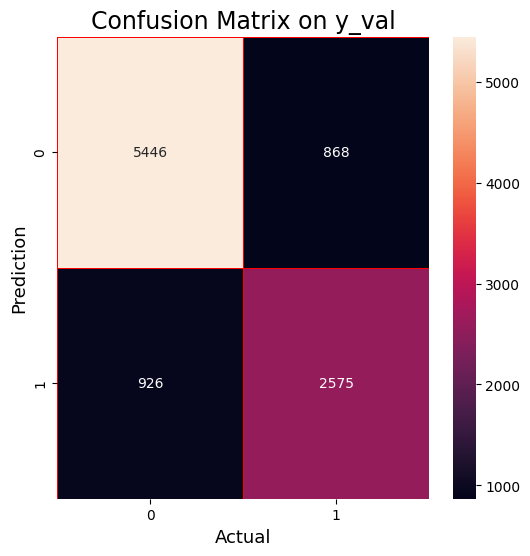

In [ ]:
# prediction on val
y_pred = best_model_xgboost.predict(x_val)

# compute the confusion matrix
cm = confusion_matrix(y_val,y_pred)

#Plot the confusion matrix.
f, ax=plt.subplots(figsize=(6,6))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix on y_val',fontsize=17)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.86      0.86      6314
         1.0       0.75      0.74      0.74      3501

    accuracy                           0.82      9815
   macro avg       0.80      0.80      0.80      9815
weighted avg       0.82      0.82      0.82      9815



### ROC-AUC

ROC Curve - One vs Rest (OvR)

Compares each class with the rest of the classes

In [ ]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations

    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes

    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''

    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]

    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate

    return tpr, fpr

In [ ]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.

    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.

    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [ ]:
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).

    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()

    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [ ]:
y_pred = best_model_xgboost.predict(x_val)
y_proba = best_model_xgboost.predict_proba(x_val)

In [ ]:
classes = best_model_xgboost.classes_
classes

array([0., 1.])

In [ ]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
classes = best_model_xgboost.classes_
roc_auc_ovr = {}
for i in range(len(classes)):
    # Gets the class
    c = classes[i]

    # Prepares an auxiliar dataframe to help with the plots
    df_aux = x_val.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_val]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)

    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 4, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")

    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 4, i+5)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")

    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()

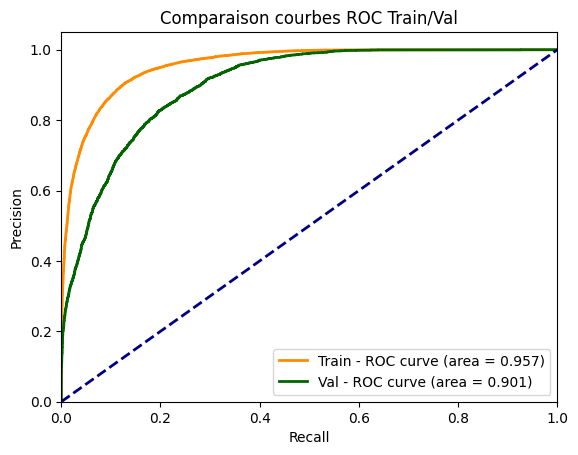

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr_train_XGB, tpr_train_XGB, thresholds_train_XGB = roc_curve(y_train, best_model_xgboost.predict_proba(x_train)[:,1])
roc_auc_train_XGB = auc(fpr_train_XGB, tpr_train_XGB)


fpr_val_XGB, tpr_val_XGB, thresholds_val_XGB = roc_curve(y_val, best_model_xgboost.predict_proba(x_val)[:,1])
roc_auc_val_XGB = auc(fpr_val_XGB, tpr_val_XGB)


plt.figure()
lw = 2
plt.plot(fpr_train_XGB, tpr_train_XGB, color='darkorange',
         lw=lw, label='Train - ROC curve (area = %0.3f)' % roc_auc_train_XGB)

plt.plot(fpr_val_XGB, tpr_val_XGB, color='darkgreen',
         lw=lw, label='Val - ROC curve (area = %0.3f)' % roc_auc_val_XGB)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Comparaison courbes ROC Train/Val')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovr:
    avg_roc_auc += roc_auc_ovr[k]
    i += 1
    print(f"{k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
print(f"average ROC AUC OvR: {avg_roc_auc/i:.4f}")

0.0 ROC AUC OvR: 0.9009
1.0 ROC AUC OvR: 0.9009
average ROC AUC OvR: 0.9009


In [ ]:
# Compares with sklearn (average only)
# "Macro" average = unweighted mean
roc_auc_score(y_val, y_proba[:,1], labels = classes, multi_class = 'ovo', average = 'macro')

0.9009158612268525

### Precision/Recall curve :



In [68]:
#Precision/Recall curve :
y_train_pred = best_model_xgboost.predict(x_train)
y_train_proba = best_model_xgboost.predict_proba(x_train)

y_val_pred = best_model_xgboost.predict(x_val)
y_val_proba = best_model_xgboost.predict_proba(x_val)

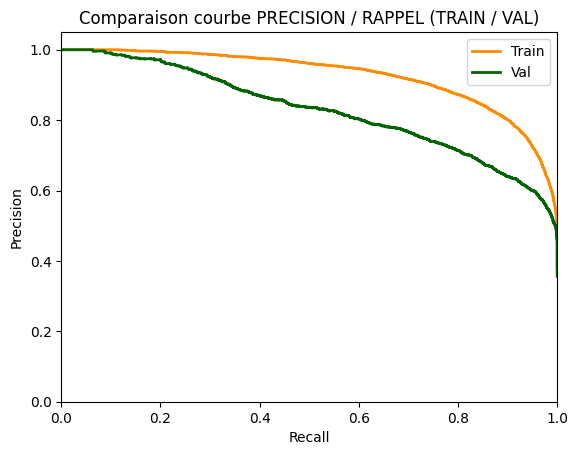

In [69]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,
                                                                         y_train_proba[:, 1])
precision_val, recall_val, thresholds_val = precision_recall_curve(y_val,
                                                                      y_val_proba[:, 1])
plt.figure()
lw = 2
plt.plot(recall_train,precision_train, color='darkorange',
         lw=lw, label='Train')

plt.plot(recall_val,precision_val, color='darkgreen',
         lw=lw, label='Val')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Comparaison courbe PRECISION / RAPPEL (TRAIN / VAL)')
plt.legend(loc="upper right")
plt.show()

In [70]:
## Choix du seuil - Optimiser le recall pour toper le plus de churner
table_choix_seuil = pd.DataFrame()
table_choix_seuil["SEUIL"] = [0] + list(thresholds_train)
table_choix_seuil["Precision_train"] = precision_train
table_choix_seuil["Recall_train"] = recall_train
table_choix_seuil.sort_values(by = "SEUIL", axis=0, ascending=False, inplace=True)

In [71]:
table_choix_seuil = pd.DataFrame(table_choix_seuil)
table_choix_seuil[table_choix_seuil["Recall_train"]>=0.95]

,SEUIL,Precision_train,Recall_train
20874,0.351706,0.725127,0.950004
20873,0.351684,0.725087,0.950004
20872,0.351679,0.725048,0.950004
20871,0.351648,0.725008,0.950004
20870,0.351645,0.724969,0.950004
...,...,...,...
4,0.000758,0.356813,1.000000
3,0.000755,0.356804,1.000000
2,0.000738,0.356795,1.000000
1,0.000719,0.356786,1.000000


In [75]:
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

best_seuil = {"seuil":0,
              "recall" : 0,
              "precision": 0,
              "tot_perte_sans_model" : 0,
              "tot_perte_avec_model": 0,
              "profit_net_sauve_grace_au_model_sur_1an" : 0}

#objectif : limiter la perte de bénéfice sur les 12 prochains mois grace au modèle, pour ca on propose une offre de reduc de 3euros sur leur forfait pour 1 an
#ex : Ici, le modele nous a permis de limiter la perte de benefice (ou profit) de 94953.59 euros sur 1 an (pour environs 9800 clients)
#cela veut dire que si on garde les churner 1 an de plus et bien : au lieu d'avoir une perte de benefice de 302486.4 (pertes sans modele), on ne perd plus que 207532.8 euros (pertes avec modele)

#forfait mensuel pour 1 client = 18 euros
#profit mensuel par client (%)= 0.4
#cout campagne d'offre de reduction pour 1 client pour 1 mois(campagne pub + offre de reduction) = 3 euros
#coût de l'offre de reduction sur 1 an = 12*3
prix_forfait_mensuel_par_client = x_train_bis.AVERAGE_CHARGE_6M.mean()/6
profit_mensuel_par_forfait_par_client_en_porucent = 0.4
profit_mensuel_par_forfait_par_client = profit_mensuel_par_forfait_par_client_en_porucent*prix_forfait_mensuel_par_client
cout_campagne_offre_par_client_par_mois = x_train_bis.AVERAGE_CHARGE_6M.mean()/6*0.2

for i in tqdm(table_choix_seuil['SEUIL']) :
    seuil = i
    y_train_predict_seuil = (y_train_proba[:, 1]>=seuil)*1

    Confusion_matrix_train = confusion_matrix(y_train, y_train_predict_seuil)
    Confusion_matrix_train = pd.DataFrame(Confusion_matrix_train)

    #calcul :
    #nb d'euros économisés pour 1 mois (faire *12 si on veut pour tous les ans)
    Tot_OBS_1 = Confusion_matrix_train[1][1] + Confusion_matrix_train[0][1] #Tot_OBS_1 = observation total de tous les churner
    TP = Confusion_matrix_train[1][1] #TP =true positive
    Tot_PRED_1 = Confusion_matrix_train[1][0] + Confusion_matrix_train[1][1] #Tot_PRED_1 = observation total de tous les churner prédit par le modèle

    tot_perte_avec_model = Tot_OBS_1*profit_mensuel_par_forfait_par_client - (TP*profit_mensuel_par_forfait_par_client - (Tot_PRED_1*cout_campagne_offre_par_client_par_mois))
    tot_perte_sans_model = Tot_OBS_1*profit_mensuel_par_forfait_par_client
    profit_net_sauve_grace_au_model_sur_1an = (tot_perte_sans_model - tot_perte_avec_model)*12

    if profit_net_sauve_grace_au_model_sur_1an > best_seuil["profit_net_sauve_grace_au_model_sur_1an"] :
        best_seuil["seuil"] = seuil
        best_seuil["recall"] = str(recall_score(y_train, y_train_predict_seuil))
        best_seuil["precision"] = str(precision_score(y_train, y_train_predict_seuil))
        best_seuil["tot_perte_sans_model"] = tot_perte_sans_model*12
        best_seuil["tot_perte_avec_model"] = tot_perte_avec_model*12
        best_seuil["profit_net_sauve_grace_au_model_sur_1an"] = profit_net_sauve_grace_au_model_sur_1an

best_seuil

100%|██████████| 39190/39190 [28:53<00:00, 22.61it/s]


{'seuil': 0.48784318566322327,
 'recall': '0.8516534533247625',
 'precision': '0.8423283413393614',
 'tot_perte_sans_model': 403049.0186401651,
 'tot_perte_avec_model': 263546.4442290344,
 'profit_net_sauve_grace_au_model_sur_1an': 139502.57441113068}

In [76]:
# Application du seuil selectionné au jeu d'apprentissage

seuil = 0.48784318566322327
y_train_predict_seuil = (y_train_proba[:, 1]>=seuil)*1

print("Metrique pour le jeu de données train : ")
print("\n Recall : " + str(recall_score(y_train, y_train_predict_seuil)))

print("\n Précision : " + str(precision_score(y_train, y_train_predict_seuil)))
Confusion_matrix_app = confusion_matrix(y_train, y_train_predict_seuil)
print(pd.DataFrame(Confusion_matrix_app))

Metrique pour le jeu de données train : 

 Recall : 0.8516534533247625

 Précision : 0.8423283413393614
       0      1
0  23010   2232
1   2077  11924


In [73]:
## Choix du seuil - Optimiser le recall/precision pour avoir le meilleur profit sur le val
table_choix_seuil_val = pd.DataFrame()
table_choix_seuil_val["SEUIL"] = [0] + list(thresholds_val)
table_choix_seuil_val["Precision_val"] = precision_val
table_choix_seuil_val["Recall_val"] = recall_val
table_choix_seuil_val.sort_values(by = "SEUIL", axis=0, ascending=False, inplace=True)

In [74]:
table_choix_seuil_val = pd.DataFrame(table_choix_seuil_val)
table_choix_seuil_val

,SEUIL,Precision_val,Recall_val
9812,0.990792,1.000000,0.000000
9811,0.990080,1.000000,0.000286
9810,0.988152,1.000000,0.000571
9809,0.981725,1.000000,0.000857
9808,0.980258,1.000000,0.001143
...,...,...,...
4,0.000813,0.356844,1.000000
3,0.000811,0.356808,1.000000
2,0.000810,0.356772,1.000000
1,0.000806,0.356735,1.000000


In [ ]:
# Application au jeu de val

best_seuil = {"seuil":0,
              "recall" : 0,
              "precision": 0,
              "tot_perte_sans_model" : 0,
              "tot_perte_avec_model": 0,
              "profit_net_sauve_grace_au_model_sur_1an" : 0}

#objectif : limiter la perte de bénéfice sur les 12 prochains mois grace au modèle, pour ca on propose une offre de reduc de 3euros sur leur forfait pour 1 an
#ex : Ici, le modele nous a permis de limiter la perte de benefice (ou profit) de 94953.59 euros sur 1 an (pour environs 9800 clients)
#cela veut dire que si on garde les churner 1 an de plus et bien : au lieu d'avoir une perte de benefice de 302486.4 (pertes sans modele), on ne perd plus que 207532.8 euros (pertes avec modele)

#forfait mensuel pour 1 client = 18 euros
#profit mensuel par client (%)= 0.4
#cout campagne d'offre de reduction pour 1 client pour 1 mois(campagne pub + offre de reduction) = 3 euros
#coût de l'offre de reduction sur 1 an = 12*3
prix_forfait_mensuel_par_client = x_val_bis.AVERAGE_CHARGE_6M.mean()/6
profit_mensuel_par_forfait_par_client_en_porucent = 0.4
profit_mensuel_par_forfait_par_client = profit_mensuel_par_forfait_par_client_en_porucent*prix_forfait_mensuel_par_client
cout_campagne_offre_par_client_par_mois = x_val_bis.AVERAGE_CHARGE_6M.mean()/6*0.2

for i in tqdm(table_choix_seuil_val['SEUIL']) :
    seuil = i
    y_val_predict_seuil = (y_val_proba[:, 1]>=seuil)*1

    Confusion_matrix_val = confusion_matrix(y_val, y_val_predict_seuil)
    Confusion_matrix_val = pd.DataFrame(Confusion_matrix_val)

    #calcul :
    #nb d'euros économisés pour 1 mois (faire *12 si on veut pour tous les ans)
    Tot_OBS_1 = Confusion_matrix_val[1][1] + Confusion_matrix_val[0][1] #Tot_OBS_1 = observation total de tous les churner
    TP = Confusion_matrix_val[1][1] #TP =true positive
    Tot_PRED_1 = Confusion_matrix_val[1][0] + Confusion_matrix_val[1][1] #Tot_PRED_1 = observation total de tous les churner prédit par le modèle

    tot_perte_avec_model = Tot_OBS_1*profit_mensuel_par_forfait_par_client - (TP*profit_mensuel_par_forfait_par_client - (Tot_PRED_1*cout_campagne_offre_par_client_par_mois))
    tot_perte_sans_model = Tot_OBS_1*profit_mensuel_par_forfait_par_client
    profit_net_sauve_grace_au_model_sur_1an = (tot_perte_sans_model - tot_perte_avec_model)*12

    if profit_net_sauve_grace_au_model_sur_1an > best_seuil["profit_net_sauve_grace_au_model_sur_1an"] :
        best_seuil["seuil"] = seuil
        best_seuil["recall"] = str(recall_score(y_val, y_val_predict_seuil))
        best_seuil["precision"] = str(precision_score(y_val, y_val_predict_seuil))
        best_seuil["tot_perte_sans_model"] = tot_perte_sans_model*12
        best_seuil["tot_perte_avec_model"] = tot_perte_avec_model*12
        best_seuil["profit_net_sauve_grace_au_model_sur_1an"] = profit_net_sauve_grace_au_model_sur_1an

best_seuil

100%|██████████| 9813/9813 [02:03<00:00, 79.53it/s] 


{'seuil': 0.5277165770530701,
 'recall': '0.6983718937446444',
 'precision': '0.7688679245283019',
 'tot_perte_sans_model': 99900.84059908304,
 'tot_perte_avec_model': 75503.46307488537,
 'profit_net_sauve_grace_au_model_sur_1an': 24397.377524197662}

In [ ]:
seuil = best_seuil["seuil"]

y_val_predict_seuil = (y_val_proba[:, 1]>=seuil)*1

print("Metrique pour le jeu de données val avec le meilleur seuil : ")

print("\n Recall : " + str(recall_score(y_val, y_val_predict_seuil)))
print("\n Précision : " + str(precision_score(y_val, y_val_predict_seuil)))

Confusion_matrix_val = confusion_matrix(y_val, y_val_predict_seuil)
print(pd.DataFrame(Confusion_matrix_val))

Metrique pour le jeu de données val avec le meilleur seuil : 

 Recall : 0.6983718937446444

 Précision : 0.7688679245283019
      0     1
0  5579   735
1  1056  2445


### Lift curve :


<Figure size 700x700 with 0 Axes>

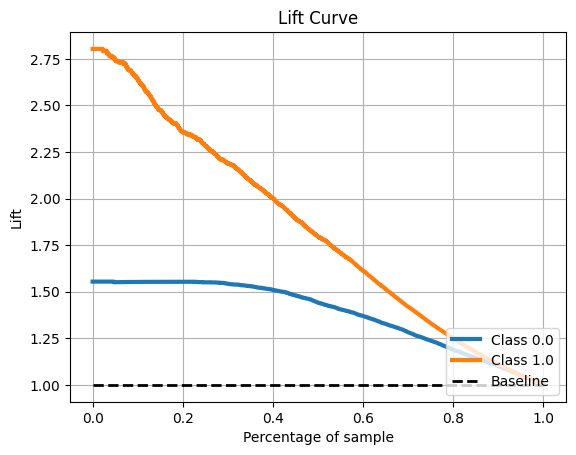

In [79]:
#courbe lift
#method 1 :
import scikitplot as skplt

plt.figure(figsize=(7,7))
y_predict_proba = best_model_xgboost.predict_proba(x_val)
skplt.metrics.plot_lift_curve(y_val,y_predict_proba)
plt.show()
plt.show()

In [80]:
res_modele=pd.DataFrame()
res_modele["Target"]=y_val
res_modele["Proba_target"]= best_model_xgboost.predict_proba(x_val)[:,1]

res_modele.sort_values(by =["Proba_target"], inplace = True,ascending=False)

res_modele['QuantileRank']= pd.qcut(res_modele["Proba_target"], q = 10, labels = False)
res_modele.head(6)

,Target,Proba_target,QuantileRank
8730,1.0,0.990792,9
2943,1.0,0.990080,9
8242,1.0,0.988152,9
4258,1.0,0.981725,9
7280,1.0,0.980258,9
6075,1.0,0.979519,9


In [ ]:
agg_tmp=pd.DataFrame(res_modele.groupby('QuantileRank')['Target'].agg(['sum','count']))
agg_tmp.sort_values(by =["QuantileRank"], inplace = True,ascending=False)
print(agg_tmp)

                sum  count
QuantileRank              
9             924.0    982
8             728.0    981
7             648.0    982
6             502.0    981
5             343.0    981
4             243.0    982
3              90.0    981
2              22.0    982
1               0.0    981
0               1.0    982


In [ ]:
agg_tmp["Precision"] = agg_tmp["sum"]/agg_tmp["count"]
agg_tmp["Proba_alatoire"]= y_val.mean()
agg_tmp["lift"]=agg_tmp["Precision"]/agg_tmp["Proba_alatoire"]
agg_tmp["Part population cible"]=agg_tmp["sum"]/y_val.sum()
agg_tmp["Part population"]=agg_tmp["count"]/y_val.count()
print(agg_tmp)

                sum  count  Precision  Proba_alatoire      lift  \
QuantileRank                                                      
9             924.0    982   0.940937        0.356699  2.637902   
8             728.0    981   0.742100        0.356699  2.080466   
7             648.0    982   0.659878        0.356699  1.849957   
6             502.0    981   0.511723        0.356699  1.434607   
5             343.0    981   0.349643        0.356699  0.980219   
4             243.0    982   0.247454        0.356699  0.693734   
3              90.0    981   0.091743        0.356699  0.257200   
2              22.0    982   0.022403        0.356699  0.062807   
1               0.0    981   0.000000        0.356699  0.000000   
0               1.0    982   0.001018        0.356699  0.002855   

              Part population cible  Part population  
QuantileRank                                          
9                          0.263925         0.100051  
8                          0.2

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

,decile,prob_min,prob_max,prob_avg,cnt_cust,cnt_resp,cnt_non_resp,cnt_resp_rndm,cnt_resp_wiz,resp_rate,cum_cust,cum_resp,cum_resp_wiz,cum_non_resp,cum_cust_pct,cum_resp_pct,cum_resp_pct_wiz,cum_non_resp_pct,KS,lift
0,1,0.816,0.991,0.906,982.0,924.0,58.0,350.1,982.0,94.094,982.0,924.0,982.0,58.0,10.005,26.392,28.049,0.919,25.473,2.638
1,2,0.665,0.816,0.737,981.0,728.0,253.0,350.1,981.0,74.210,1963.0,1652.0,1963.0,311.0,20.000,47.187,56.070,4.926,42.261,2.359
2,3,0.552,0.664,0.605,982.0,648.0,334.0,350.1,982.0,65.988,2945.0,2300.0,2945.0,645.0,30.005,65.696,84.119,10.215,55.481,2.190
3,4,0.447,0.552,0.500,981.0,502.0,479.0,350.1,556.0,51.172,3926.0,2802.0,3501.0,1124.0,40.000,80.034,100.000,17.802,62.232,2.001
4,5,0.329,0.446,0.388,982.0,343.0,639.0,350.1,0.0,34.929,4908.0,3145.0,3501.0,1763.0,50.005,89.831,100.000,27.922,61.909,1.796
5,6,0.192,0.329,0.263,981.0,243.0,738.0,350.1,0.0,24.771,5889.0,3388.0,3501.0,2501.0,60.000,96.772,100.000,39.610,57.162,1.613
6,7,0.074,0.192,0.128,982.0,90.0,892.0,350.1,0.0,9.165,6871.0,3478.0,3501.0,3393.0,70.005,99.343,100.000,53.738,45.605,1.419
7,8,0.013,0.074,0.040,981.0,22.0,959.0,350.1,0.0,2.243,7852.0,3500.0,3501.0,4352.0,80.000,99.971,100.000,68.926,31.045,1.250
8,9,0.001,0.013,0.005,982.0,0.0,982.0,350.1,0.0,0.000,8834.0,3500.0,3501.0,5334.0,90.005,99.971,100.000,84.479,15.492,1.111
9,10,0.001,0.001,0.001,981.0,1.0,980.0,350.1,0.0,0.102,9815.0,3501.0,3501.0,6314.0,100.000,100.000,100.000,100.000,0.000,1.000


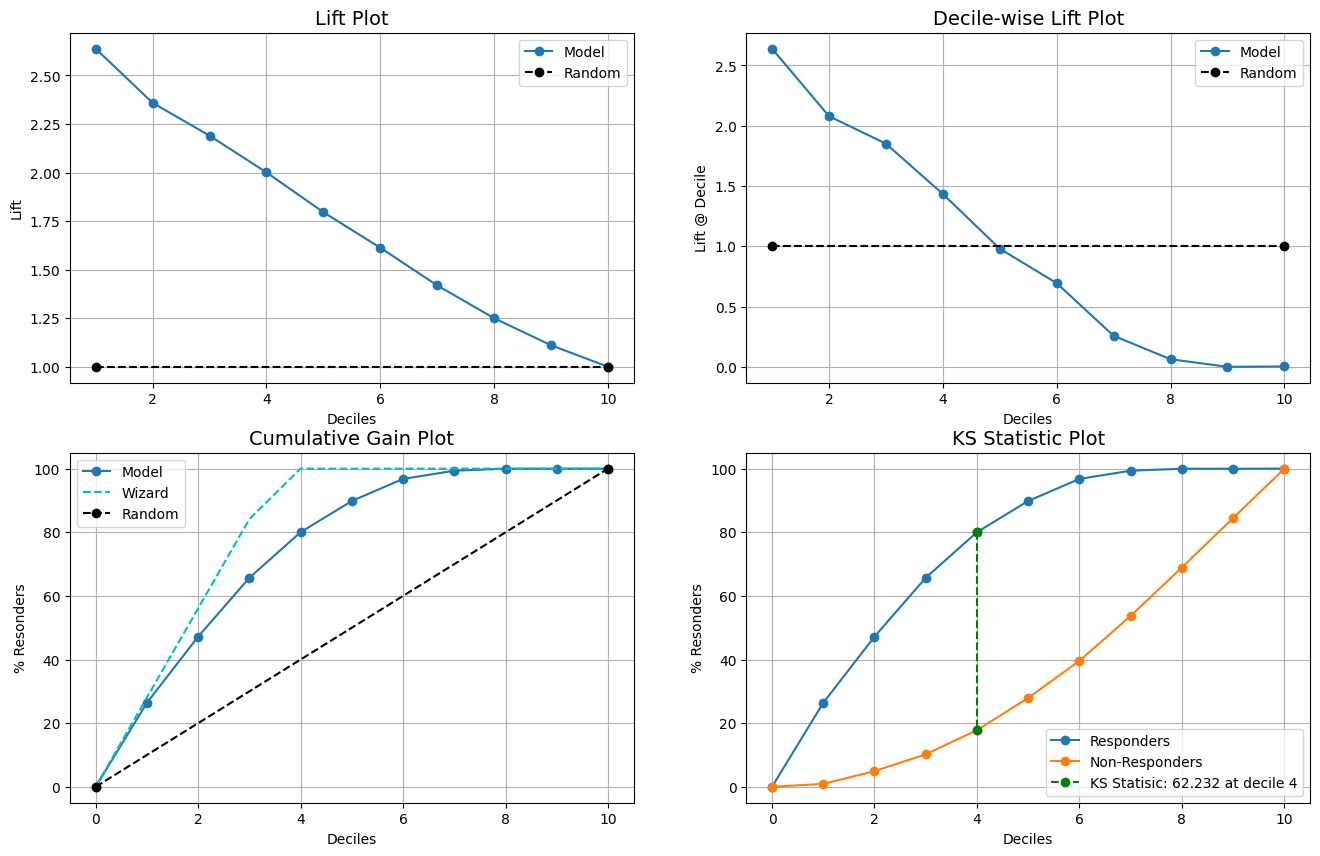

In [85]:
#methode 2 :
import kds
kds.metrics.report(y_val, best_model_xgboost.predict_proba(x_val)[:,1])

<a class="anchor" id="section_5_2"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">Identification des variables les plus importantes</h3>
</div>

In [ ]:
(pd.DataFrame({'Features': best_model_xgboost.feature_names_in_,
              'Features importance (in %)': (best_model_xgboost.feature_importances_)*100})).sort_values(by='Features importance (in %)', ascending=False)

,Features,Features importance (in %)
66,FLAG_RECHARGE_M2,51.517773
9,LAST_RECHARGE_VALUE,10.720792
11,TIME_TO_AFTERGRACE,2.929370
12,RECENCY_OF_LAST_RECHARGE,2.396509
69,AVERAGE_MULTIPLE_RECHARGE_M1_M2_M3,2.073517
...,...,...
49,OUT_VMACC_NO_CALLS_M2,0.255822
50,OUT_VMACC_NO_CALLS_M3,0.249989
46,OUT_888_DURATION_MINS_M1,0.243762
77,CUSTOMER_GENDER_male,0.235158


# Learning curve :

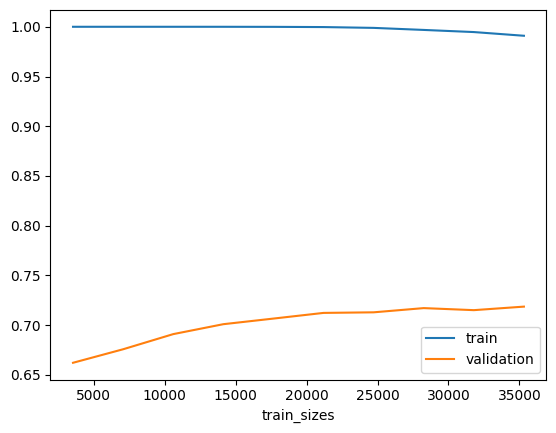

In [ ]:
#add tool box
from sklearn.model_selection import learning_curve
from matplotlib import pyplot as plt
import numpy as np

N, train_score, val_score = learning_curve(best_model, x_train, y_train, train_sizes= np.linspace(0.1,1,10) ,cv=10, scoring="f1") #or f1_weighted

plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

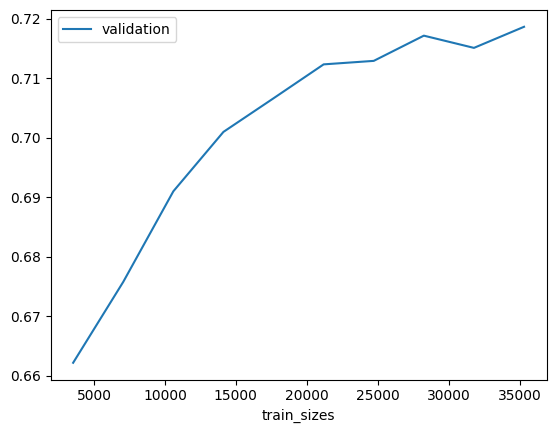

In [ ]:
N, train_score, val_score = learning_curve(best_model, x_train, y_train, train_sizes= np.linspace(0.1,1,10) ,cv=10, scoring="f1")

#plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

<a class="anchor" id="section_5_3"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">Interprétation du modèle</h3>
</div>

In [81]:
#General :
# compute the SHAP values for the linear model
explainer = shap.Explainer(best_model_xgboost.predict, x_train)
shap_values = explainer(x_train[:1000])

Permutation explainer: 1001it [03:36,  4.63it/s]


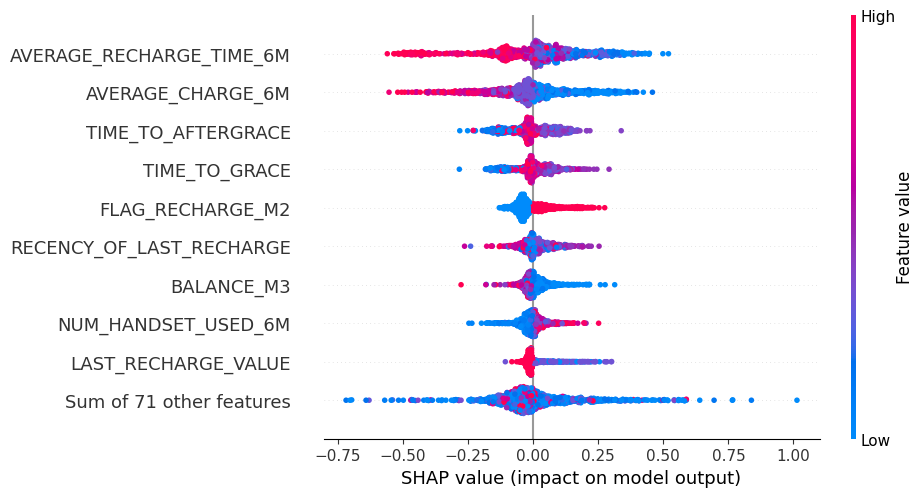

In [82]:
shap.plots.beeswarm(shap_values)

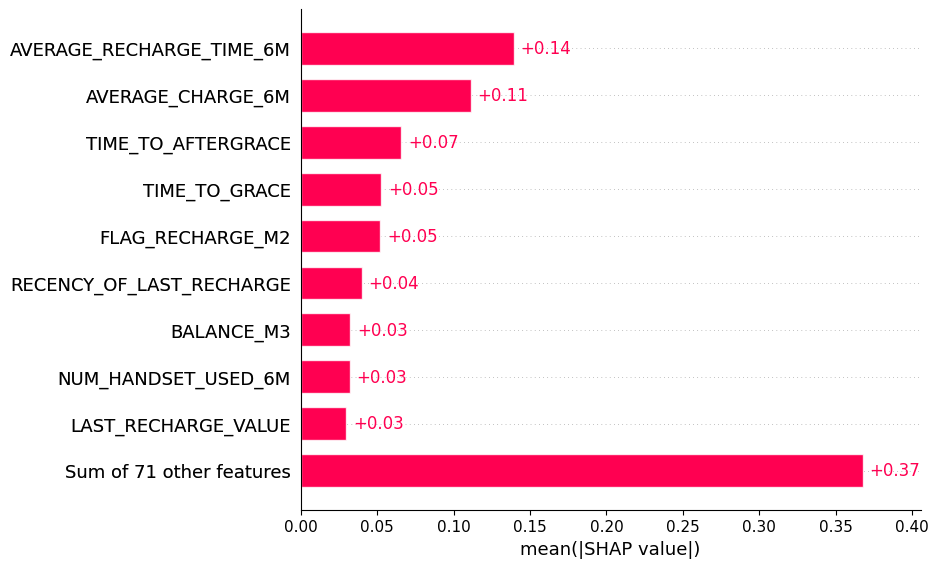

In [83]:
shap.plots.bar(shap_values)

<a class="anchor" id="section_5_4"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">Sérialisation du modèle et déploiement en situation réelle</h3>
</div>

In [ ]:
#the best model is model(hyper-param)

joblib.dump(value = best_model_xgboost, filename = '/home/jupyter/model/scoring_model.pkl')

['/home/jupyter/model/scoring_model.pkl']

In [ ]:
#load model :
scoring_model = joblib.load(filename = '/home/jupyter/model/scoring_model.pkl')

In [ ]:
#predict churn : (to review)
def predict_churn(model, feature_dict):

    df_for_pred = pd.DataFrame(feature_dict)

    df_for_pred["FLAG_RECHARGE_M1"] = df_for_pred["RECENCY_OF_LAST_RECHARGE"].apply(lambda x : 1 if 0 <= x <= 31 else 0)
    df_for_pred["FLAG_RECHARGE_M2"] = df_for_pred["RECENCY_OF_LAST_RECHARGE"].apply(lambda x : 1 if 32 <= x <= 62 else 0)
    df_for_pred["FLAG_RECHARGE_M3"] = df_for_pred["RECENCY_OF_LAST_RECHARGE"].apply(lambda x : 1 if 63 <= x <= 92 else 0)
    df_for_pred["FLAG_RECHARGE_PLUS_M3"] = df_for_pred["RECENCY_OF_LAST_RECHARGE"].apply(lambda x : 1 if x >= 93 else 0)

    for index, row in df_for_pred.iterrows():
        if row["BALANCE_M1"] > row["BALANCE_M2"] and row["BALANCE_M2"] > row["BALANCE_M3"] :
            df_for_pred.at[index, "AVERAGE_MULTIPLE_RECHARGE_M1_M2_M3"] = 1

        else :
            df_for_pred.at[index, "AVERAGE_MULTIPLE_RECHARGE_M1_M2_M3"] = 0

    for index, row in df_for_pred.iterrows() :
        if row["INC_DURATION_MINS_M1"] + row["INC_PROP_SMS_CALLS_M1"] == 0 :
            df_for_pred.at[index, "FLAG_IN_M1"] = 0
        else :
            df_for_pred.at[index, "FLAG_IN_M1"] = 1
        if row["INC_DURATION_MINS_M2"] + row["INC_PROP_SMS_CALLS_M2"] == 0 :
            df_for_pred.at[index, "FLAG_IN_M2"] = 0
        else :
            df_for_pred.at[index, "FLAG_IN_M2"] = 1
        if row["INC_DURATION_MINS_M3"] + row["INC_PROP_SMS_CALLS_M3"] == 0 :
            df_for_pred.at[index, "FLAG_IN_M3"] = 0
        else :
            df_for_pred.at[index, "FLAG_IN_M3"] = 1

    for index, row in df_for_pred.iterrows() :
        if row["OUT_DURATION_MINS_M1"] + row["OUT_SMS_NO_M1"] + row["OUT_INT_DURATION_MINS_M1"] + row["OUT_888_DURATION_MINS_M1"] + row["OUT_VMACC_NO_CALLS_M1"] == 0 :
            df_for_pred.at[index, "FLAG_OUT_M1"] = 0
        else :
            df_for_pred.at[index, "FLAG_OUT_M1"] = 1
        if row["OUT_DURATION_MINS_M2"] + row["OUT_SMS_NO_M2"] + row["OUT_INT_DURATION_MINS_M2"] + row["OUT_888_DURATION_MINS_M2"] + row["OUT_VMACC_NO_CALLS_M2"] == 0 :
            df_for_pred.at[index, "FLAG_OUT_M2"] = 0
        else :
            df_for_pred.at[index, "FLAG_OUT_M2"] = 1
        if row["OUT_DURATION_MINS_M3"] + row["OUT_SMS_NO_M3"] + row["OUT_INT_DURATION_MINS_M3"] + row["OUT_888_DURATION_MINS_M3"] + row["OUT_VMACC_NO_CALLS_M3"] == 0 :
            df_for_pred.at[index, "FLAG_OUT_M3"] = 0
        else :
            df_for_pred.at[index, "FLAG_OUT_M3"] = 1

    for index, row in df_for_pred.iterrows() :
        if row["CONTRACT_TENURE_DAYS"] > 730 :
            df_for_pred.at[index, "OLD_CONTRACT"] = 1
        else :
            df_for_pred.at[index,"OLD_CONTRACT"] = 0

    # 1st feature selection :
    df_for_pred.drop(list_col_to_drop, axis=1, inplace=True)

    # Encode only cat features :
    df_for_pred = a.pre_processing(df=df_for_pred, train=False, categorical_var_OHE= list_cat_col_OHE,
                                   categorical_var_OrdinalEncoding={}, categorical_var_TE=list_cat_col_TE, target=y_train,
                                   continious_var=[], encoding_type_cont=StandardScaler())

    # 2nd feature selection RFE :
    df_for_pred = df_for_pred[list(selector.get_feature_names_out())]
    
    #df_for_pred = df_for_pred[scoring_model.get_booster().feature_names]

    return {"Churn" : (model.predict(df_for_pred))[0] ,
            "Proba 0 ": [round(elem, 2) for elem in list(model.predict_proba(df_for_pred)[0])][0],
            "Proba 1 ": [round(elem, 2) for elem in list(model.predict_proba(df_for_pred)[0])][1]
           } , df_for_pred


In [ ]:
#example of prediction on random observation :
feature_dict = {'CUSTOMER_AGE': [43],'CONTRACT_TENURE_DAYS': [1168.0], 'AVERAGE_CHARGE_6M': [25.0], 'FAILED_RECHARGE_6M': [0],
             'AVERAGE_RECHARGE_TIME_6M': [200], 'BALANCE_M3': [30.24], 'BALANCE_M2': [77.64], 'BALANCE_M1': [98.44],
             'FIRST_RECHARGE_VALUE': [100], 'LAST_RECHARGE_VALUE': [50], 'TIME_TO_GRACE': [-20], 'TIME_TO_AFTERGRACE': [-30],
             'RECENCY_OF_LAST_RECHARGE': [10], 'TOTAL_RECHARGE_6M': [200],'NO_OF_RECHARGES_6M': [3], 'ZERO_BALANCE_IND_M2': [0],
             'ZERO_BALANCE_IND_M1': [0], 'PASS_GRACE_IND_M3': [1], 'PASS_GRACE_IND_M2': [1], 'PASS_GRACE_IND_M1': [1],
             'PASS_AFTERGRACE_IND_M3': [0], 'PASS_AFTERGRACE_IND_M2': [0], 'DATA_FLAG': [1], 'INT_FLAG': [0], 'NUM_HANDSET_USED_6M': [2],
             'INC_DURATION_MINS_M3': [37], 'INC_PROP_SMS_CALLS_M3': [0], 'INC_PROP_OPE1__MIN_M1': [0.52], 'INC_PROP_OPE2_MIN_M1': [0.32],
             'INC_PROP_OPE2_MIN_M2': [0.4],'INC_PROP_FIXED_MIN_M1': [0.16],'INC_PROP_FIXED_MIN_M3': [0.46],'OUT_DURATION_MINS_M2': [22],
             'OUT_DURATION_MINS_M3': [12],'OUT_SMS_NO_M1': [6],'OUT_SMS_NO_M2': [3],'OUT_SMS_NO_M3': [3],'OUT_INT_DURATION_MINS_M1': [0],
             'OUT_INT_DURATION_MINS_M2': [0],'OUT_888_DURATION_MINS_M1': [0],'OUT_888_DURATION_MINS_M2': [0],'OUT_888_DURATION_MINS_M3': [0],
             'OUT_VMACC_NO_CALLS_M2': [0],'OUT_VMACC_NO_CALLS_M3': [1],'OUT_PROP_SMS_CALLS_M1': [0.2],'OUT_PROP_SMS_CALLS_M2': [0.19],
             'OUT_PROP_SMS_CALLS_M3': [0.25],'OUT_PROP_OPE1__MIN_M1': [0.58],'OUT_PROP_OPE1__MIN_M2': [0],'OUT_PROP_OPE1__MIN_M3': [0],
             'OUT_PROP_OPE2_MIN_M1': [0],'OUT_PROP_FIXED_MIN_M1': [0],'OUT_PROP_FIXED_MIN_M2': [0.05],'OUT_PROP_FIXED_MIN_M3': [0],
             'INC_OUT_PROP_DUR_MIN_M1': [3.13],'INC_OUT_PROP_DUR_MIN_M2': [1.59],'INC_OUT_PROP_DUR_MIN_M3': [3.08],
             'CUSTOMER_GENDER': ["male"],'ZERO_BALANCE_IND_M3': [0],'ROAM_FLAG': [0],'INC_DURATION_MINS_M2': [0], 'INC_PROP_SMS_CALLS_M1': [0], 'INC_DURATION_MINS_M1':[0],
             'INC_PROP_OPE1__MIN_M3': [0],'INC_PROP_FIXED_MIN_M2': [0],'OUT_INT_DURATION_MINS_M3': [0],'OUT_PROP_OPE2_MIN_M2': [0],'OUT_PROP_OPE2_MIN_M3': [0],
             'INC_PROP_SMS_CALLS_M3': [1],  "OUT_DURATION_MINS_M1":[1], 'INC_PROP_SMS_CALLS_M2': [0], 'INC_DURATION_MINS_M1':[0], "marque": ["nokia"],
             'PASS_AFTERGRACE_IND_M1' : [0], 'INC_PROP_OPE1__MIN_M2': [0], 'INC_PROP_OPE2_MIN_M3': [0], 'OUT_VMACC_NO_CALLS_M1': [0]}

predict_churn(scoring_model, feature_dict)[0]

{'Churn': 1, 'Proba 0 ': 0.37, 'Proba 1 ': 0.63}

### Explication du résultat avec Shapley value

In [ ]:
df_p_h = predict_churn(scoring_model, feature_dict)[1]

In [ ]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(best_model_xgboost.predict, x_train)
shap_values = explainer(df_p_h)

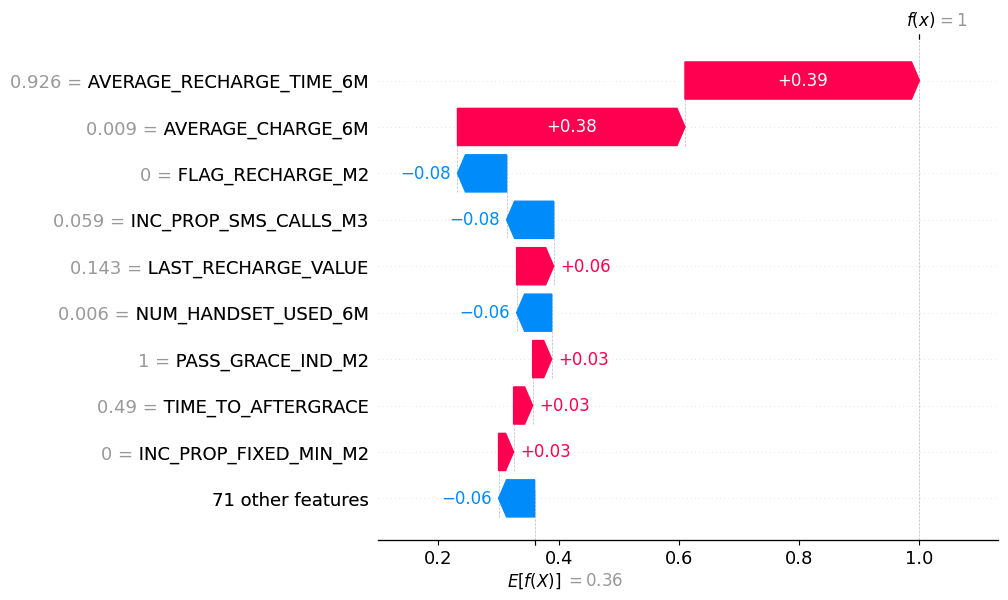

In [ ]:
#particular

#The additive nature of Shapley values
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[0], max_display=10)